In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# card 데이터 로드
card = pd.read_csv("CARD_SPENDING_RESIDENT.txt", sep="\t")

card_dong = pd.read_excel("card_instruct.xlsx", sheet_name=1, header=1).drop('Unnamed: 0', axis=1)

card = card.merge(card_dong, how='left', left_on = ['GU_CD', 'DONG_CD'], right_on = ['구코드', '행정동코드'])

line = pd.read_excel("card_instruct.xlsx",sheet_name = 2, header=1).drop("Unnamed: 0", axis=1)
line_code = pd.DataFrame(line['업종코드 (32개 분류)'].dropna())
line_code.reset_index(drop=True, inplace = True)

code_list = []
line_list = []

for line in line_code['업종코드 (32개 분류)']:
    code = line[-3:-1]
    name = line[:-4]
    
    code_list.append(code)
    line_list.append(name)
    
line_dic = {
    'MCT_CAT_CD' : code_list,
    'MCT_CAT_NM' : line_list
}

#업종별 테이블 생성
line_table = pd.DataFrame(line_dic)
# 카드 데이터와 맞추기 위해 타입변경
line_table['MCT_CAT_CD'] = line_table['MCT_CAT_CD'].astype("int64")

card = card.merge(line_table, how='left', on = 'MCT_CAT_CD')


card.drop(['GU_CD', 'DONG_CD','MCT_CAT_CD', 'SEX_CD', 'AGE_CD', '구코드', '행정동코드'], axis=1,inplace=True)


card.columns = ['일자', '이용건수', '이용금액','구명','행정동명','업종명']

In [3]:
# cj 물류 파일 로드
os.chdir("./cj")

cj = pd.read_excel('cj_data.xlsx')

# cj 데이터 일자 양식맞추기
cj['DL_YMD'] = cj['DL_YMD'] + 20000000

cj.drop(['DL_GD_LCLS_CD','CTPV_CD', 'CTGG_CD','HDNG_CD'], axis=1, inplace=True)

cj.columns = ['일자', '업종명', '시명', '구명', '행정동명', '물류건수']

In [6]:
# gs 유통파일 로드
gs = pd.read_excel('../gs_retail.xlsx', sheet_name = 5)

gs.columns = ['일자', '시명', '구명', '행정동명', '매출지수', '식사_비중', '간식_비중', '마실거리_비중', '홈&리빙_비중', '헬스&뷰티_비중', '취미&여가활동_비중', '사회활동_비중', '임신/육아_비중']

In [7]:
# sk 유동인구 파일 로드
os.chdir('../sk')
files_sk = os.listdir()

sk = pd.DataFrame()

for file in files_sk[:8]:
    temp = pd.read_csv(file, sep="|")
    
    sk = sk.append(temp)

In [8]:
# 각 일자별 동의 유동인구 합산량을 바탕으로 분석을 진행하기 위해 'sum_flow' 컬럼 생성
# 유동인구를 나타내는 칼럼들
num_columns = ['MAN_FLOW_POP_CNT_0004',
       'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
       'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
       'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
       'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']
sk['sum_flow'] = sk[num_columns].sum(axis=1)

sk.drop(['STD_YM', 'HDONG_CD']+num_columns, axis=1,inplace=True)

sk.columns = ['일자', '행정동명', '유동인원']

In [9]:
# 각 데이터의 행정동 unique() 개수가 달라 추가 조사
print(f"sk 행정동 개수 : {len(sk['행정동명'].unique())}")
print(f"cj 행정동 개수 : {len(cj['행정동명'].unique())}")
print(f"card 행정동 개수 : {len(card['행정동명'].unique())}")
print(f"gs 행정동 개수 : {len(gs['행정동명'].unique())}")

sk 행정동 개수 : 69
cj 행정동 개수 : 69
card 행정동 개수 : 69
gs 행정동 개수 : 60


In [10]:
len(sk['행정동명'].unique())

69

In [11]:
len(sk['행정동명'].drop_duplicates())

69

In [12]:
# 겹치는 주어진 데이터에 겹치는 행정동명이 있는지 확인 
len(cj[['시명', '구명', '행정동명']].drop_duplicates()) #확인결과 없음

69

In [13]:
len(cj['행정동명'].drop_duplicates())

69

In [14]:
# cj에는 있고 gs에는 없는 행정동명 색출
empty_dong = list(set(cj['행정동명'].unique()) - set(gs['행정동명'].unique()))

In [15]:
empty_dong

['만촌2동', '신당제5동', '남산3동', '남산2동', '대봉1동', '대봉2동', '상동', '대신동', '상계8동', '파동']

In [16]:
# cj의 시/구/행정동 정보를 추출
dong_info  = cj[['시명', '구명', '행정동명']].drop_duplicates()
dong_info.reset_index(drop=True, inplace=True)

In [17]:
difference_index = dong_info[dong_info['행정동명'].isin(empty_dong)].index.tolist()

# 겹치지 않는 10개동을 제외한 총 59개의 동을 분석 대상으로 선정
dong_info.drop(difference_index, axis=0,inplace=True)
dong_info.reset_index(drop=True, inplace=True)

In [18]:
# 선정된 시, 구, 동을 기준으로 나머지 데이터와 통일
sk = sk.merge(dong_info, how='inner', on='행정동명')
card.drop("구명", axis=1, inplace=True)
card = card.merge(dong_info, how='inner', on='행정동명')
gs.drop(['시명', '구명'], axis=1, inplace=True)
gs = gs.merge(dong_info, how='inner', on='행정동명')
cj.drop(['시명','구명'], axis=1, inplace=True)
cj = cj.merge(dong_info, how = 'inner', on = '행정동명')

In [19]:
# 년, 월, 일, 주차를 추가하기 위한 함수
def datetime_format(df):
    df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d', errors='raise')
    df['년'] = df['일자'].dt.year
    df['월'] = df['일자'].dt.month
    df['일'] = df['일자'].dt.day
    df['주차'] = df['일자'].dt.weekofyear
    
    return df

In [20]:
data = [sk, card, gs, cj]

# 각 데이터 년/월/일 추가
[datetime_format(x) for x in data]

# 5주차의 데이터는 2019년의 경우 3일, 2020년의 경우 2일이 포함됨.
# 22주차의 데이터는 2019년의 5일, 2020년의 경우 7일 모두 포함됨
# 이에따라 19년 대비 20년의 수치를 비교하기에는 기준이 다르다고 판단하여
# 5주차, 22주차의 데이터는 분석에서 제외

sk = sk[sk['주차'].isin(range(6,22))].reset_index(drop=True)
cj = cj[cj['주차'].isin(range(6,22))].reset_index(drop=True)
card = card[card['주차'].isin(range(6,22))].reset_index(drop=True)
gs = gs[gs['주차'].isin(range(6,22))].reset_index(drop=True)

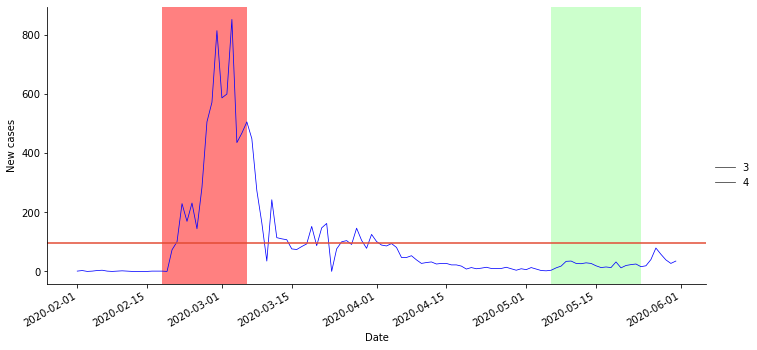

In [21]:
# 코로나 데이터 로드(from Kaggle)
corona = pd.read_csv("../corona/full_grouped.csv")

# 한국의 확진자 데이터만을 확보
korea_corona = corona[corona['Country/Region'] == 'South Korea']
korea_corona.reset_index(drop=True, inplace=True)

# 분석 대상인 2월 1일 ~ 5월 31일 데이터만 추출
korea_corona['Date'] = pd.to_datetime(korea_corona['Date'], format="%Y-%m-%d")
korea_corona['year'] = korea_corona['Date'].dt.year
korea_corona['month'] = korea_corona['Date'].dt.month
korea_corona['day'] = korea_corona['Date'].dt.day
korea_corona['week'] = korea_corona['Date'].dt.weekofyear

korea_corona = korea_corona[korea_corona['month'].isin(range(2,6))]

# 일자별 코로나 추이
g = sns.relplot(x='Date', y='New cases', data = korea_corona, kind='line', size=4, aspect=2, color='blue')
g.fig.autofmt_xdate()

plt.axhline(korea_corona['New cases'].mean())

span_start_1 = pd.datetime(2020, 2, 18)
span_end_1 =pd.datetime(2020,3 ,6)

span_start_2 = pd.datetime(2020,5,6)
span_end_2 = pd.datetime(2020,5,24)
plt.axvspan(span_start_1, span_end_1, facecolor=(1, 0.5, 0.5), alpha=1)
plt.axvspan(span_start_2, span_end_2, facecolor=(0.8, 1, 0.8), alpha=1)
plt.style.use('ggplot')

## 코로나 확산기에 각 동이 보여주는 특징을 잡아 군집화한 후 각 집단의 코로나 안정기의 소비 행태를 분석하면 진정한 뉴노멀 시대의 소비 트랜드를 보여줄 수 있지 않을까?

In [1190]:
# 스케일링 함수
from sklearn.preprocessing import MinMaxScaler

def get_scaled(df, col = ""):
    scaler = MinMaxScaler()
    scaler.fit(np.array(df[col]).reshape(-1, 1))
    return np.round(scaler.transform(np.array(df[col]).reshape(-1,1)), 2)

# 지수 얻는 함수
def get_index_table(df, col_name = ""):
    df_index = df.pivot_table(index=['주차', '시명', '구명', '행정동명', '년'], values=[col_name], aggfunc='mean')
    
    df_index_2019 = df_index.xs(2019,level=4, axis=0).reset_index()
    df_index_2020 = df_index.xs(2020,level=4, axis=0).reset_index()
    
    df_index = df_index_2019.merge(df_index_2020, how='inner', on = ['주차', '시명', '구명', '행정동명'])
    
    return df_index

# 행정동 별 시각화 함수
def get_plot_trend(df, x_axis, gu_name, index = "", rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df[index].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index][x_axis].values
    sns.barplot(x = x_axis, y=index, data=df, order=plot_order)
    plt.axhline(df[index].mean())
    df = df.sort_values(by=index, ascending=False)
    df[index] = np.round(df[index],2)
    for idx, score in enumerate(df[index]):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')
    plt.style.use('ggplot')
        
# elbow 함수
def elbow(x):
    k = []
    sse = []
    
    for i in range(1, 11):
        model = KMeans(n_clusters = i, random_state=1015)
        model.fit(x)
        sse.append(model.inertia_)
        k.append(i)
        
    plt.plot(k, sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.xticks(range(1,11))
    plt.style.use('ggplot')
    plt.show() 

# 지수 테이블 얻는 함수
def get_line_index_table(df, col_name = ""):
    df_index = df.pivot_table(index=['주차', '시명', '구명', '행정동명', '년', '업종명'], values=[col_name], aggfunc='sum')
    
    df_index_2019 = df_index.xs(2019,level=4, axis=0).reset_index()
    df_index_2020 = df_index.xs(2020,level=4, axis=0).reset_index()
    
    df_index = df_index_2019.merge(df_index_2020, how='inner', on = ['주차', '시명', '구명', '행정동명','업종명'])
    
    return df_index

# 업종별 시각화 함수
def get_plot_by_line(df, index=""):
    plt.figure(figsize=(18, 6))
    
    top_down_index = df[index].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['업종명'].values
    sns.barplot(x = '업종명', y=index, data=df, order = plot_order)  
    plt.axhline(df[index].mean())
    df = df.sort_values(by=index, ascending=False)
    plt.style.use('ggplot')
#     df[index] = np.round(df[index],5)
#     for idx, score in enumerate(df[index]):
#         plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

# 항목 전체 모아보기 함수
def get_plot_by_total_line(df, index=""):
    tmp_df = pd.DataFrame()
    fig = plt.figure(figsize=(21, 30))
    lines = df['업종명'].unique()
    
    for idx, line in enumerate(lines):
        plt.subplot(6,4,idx+1)
        tmp_df = df[df['업종명'] == line]    
        sns.barplot(x ='업종명', y=index, hue='그룹', data = tmp_df)
        plt.legend()
        
#         plt.yticks([0, 50, 100, 150, 200, 250])
        
    plt.style.use('ggplot')
    
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
# 이동평균 추세 시각화
def get_MA_trend(df, index1="", index2=""):
    tmp = pd.DataFrame()
    tmp[index1] = df[index1].rolling(window=3, min_periods=1).mean()
    tmp[index2] = df[index2].rolling(window=3, min_periods=1).mean()
    
    plt.figure(figsize=(18,6))
    tmp[index1].plot(color='blue')
    tmp[index2].plot(color='red')
    
    plt.legend([index1, index2], loc='upper left')
    
# 주차별 추세 시각화
def get_week_trend(df, index1="", index2=""):
    plt.figure(figsize=(18, 6))
    df.groupby('주차')[index1].mean().plot(color='blue')
    df.groupby('주차')[index2].mean().plot(color='red')
    plt.axvline(x=6, color='red')
    plt.axvline(x=9, color='red')

    plt.xticks(range(6,22))
    plt.legend([index1, index2], loc='upper')
    plt.axvspan(6, 9, facecolor=(1,0.5,0.5), alpha=1)
    plt.axvspan(19, 21, facecolor=(0.8, 1, 0.8), alpha=1)

    plt.axvline(x=19, color='skyblue')
    plt.axvline(x=21, color='skyblue')
    plt.style.use('ggplot')

In [1191]:
span_start_1 = pd.datetime(2020, 2, 18)
span_end_1 =pd.datetime(2020,3 ,6)

span_start_2 = pd.datetime(2020,5,6)
span_end_2 = pd.datetime(2020,5,24)

In [1192]:
# 일자별 전반적인 카드소비 트랜드를 보기위해 데이터 추출
card_MA = card.pivot_table(index=['일자','년','월','일','주차'], values = ['이용건수', '이용금액'], aggfunc='sum').reset_index()

# 19년도와 20년도 데이터 분리
card_MA_2019 = card_MA[card_MA['년'] == 2019]
card_MA_2020 = card_MA[card_MA['년'] == 2020]

# 카드 매출의 숨겨진 추세를 파악하기 위해 이동평균값 확인
card_MA_2019['이동평균_금액'] = card_MA_2019['이용금액'].rolling(window=3, min_periods=1).mean()
card_MA_2020['이동평균_금액'] = card_MA_2020['이용금액'].rolling(window=3, min_periods=1).mean()
card_MA_2019['이동평균_건수'] = card_MA_2019['이용건수'].rolling(window=3, min_periods=1).mean()
card_MA_2020['이동평균_건수'] = card_MA_2020['이용건수'].rolling(window=3, min_periods=1).mean()

card_MA_2019.reset_index(drop=True, inplace=True)
card_MA_2020.reset_index(drop=True, inplace=True)

In [1193]:
card_MA_2020[card_MA_2020['월']==2]

,일자,년,월,일,주차,이용건수,이용금액,이동평균_금액,이동평균_건수
0,2020-02-03,2020,2,3,6,1052392,22591398,2.259140e+07,1.052392e+06
1,2020-02-04,2020,2,4,6,1038124,22881389,2.273639e+07,1.045258e+06
2,2020-02-05,2020,2,5,6,1028617,22878980,2.278392e+07,1.039711e+06
3,2020-02-06,2020,2,6,6,1033425,22888969,2.288311e+07,1.033389e+06
4,2020-02-07,2020,2,7,6,1133745,27576413,2.444812e+07,1.065262e+06
5,2020-02-08,2020,2,8,6,1054662,27520958,2.599545e+07,1.073944e+06
6,2020-02-09,2020,2,9,6,829191,18334278,2.447722e+07,1.005866e+06
7,2020-02-10,2020,2,10,7,1069654,22168397,2.267454e+07,9.845023e+05
8,2020-02-11,2020,2,11,7,1101532,24976354,2.182634e+07,1.000126e+06
9,2020-02-12,2020,2,12,7,1046008,23374138,2.350630e+07,1.072398e+06


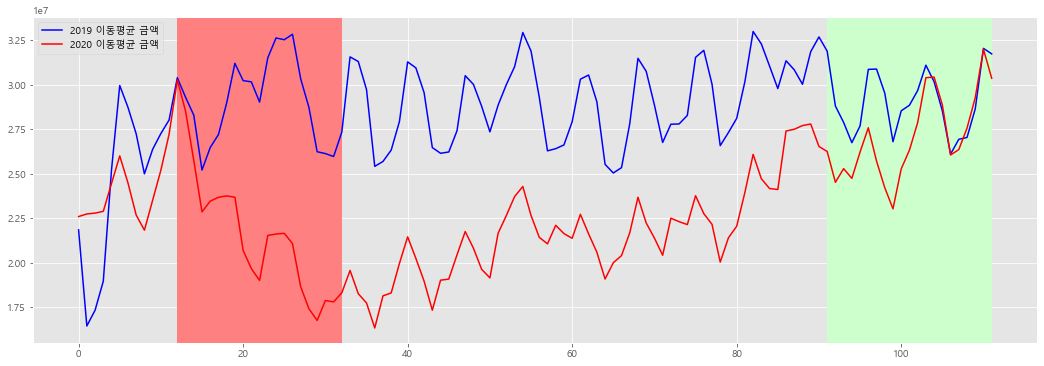

In [1194]:
plt.figure(figsize=(18, 6))

card_MA_2019['이동평균_금액'].plot(color='blue')
card_MA_2020['이동평균_금액'].plot(color='red')

plt.axvspan(12, 32, facecolor=(1, 0.5, 0.5), alpha=1)
plt.axvspan(91, 111, facecolor=(0.8, 1, 0.8), alpha=1)
plt.legend(['2019 이동평균 금액', '2020 이동평균 금액'])
plt.style.use('ggplot')

In [1195]:
# 주차별 이동평균 값의 평균값 산출
card_MA_2019_week = card_MA_2019.groupby("주차")['이동평균_금액', '이동평균_건수'].mean()
card_MA_2020_week = card_MA_2020.groupby("주차")['이동평균_금액', '이동평균_건수'].mean()

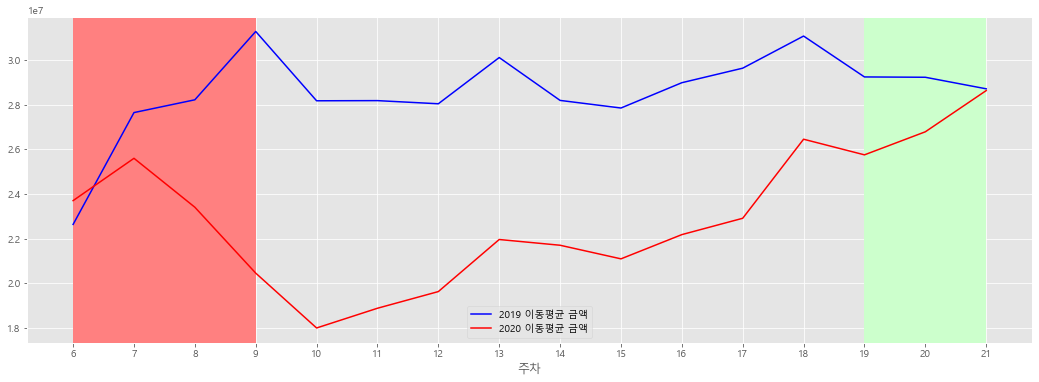

In [1196]:
plt.figure(figsize=(18, 6))


card_MA_2019_week['이동평균_금액'].plot(color='blue')
card_MA_2020_week['이동평균_금액'].plot(color='red')

plt.xticks(range(6,22))
plt.axvspan(6, 9, facecolor=(1,0.5,0.5), alpha=1)
plt.axvspan(19, 21, facecolor=(0.8, 1, 0.8), alpha=1)
plt.legend(['2019 이동평균 금액', '2020 이동평균 금액'])
plt.style.use('ggplot')

#### 카드 매출의 이동평균 트랜드

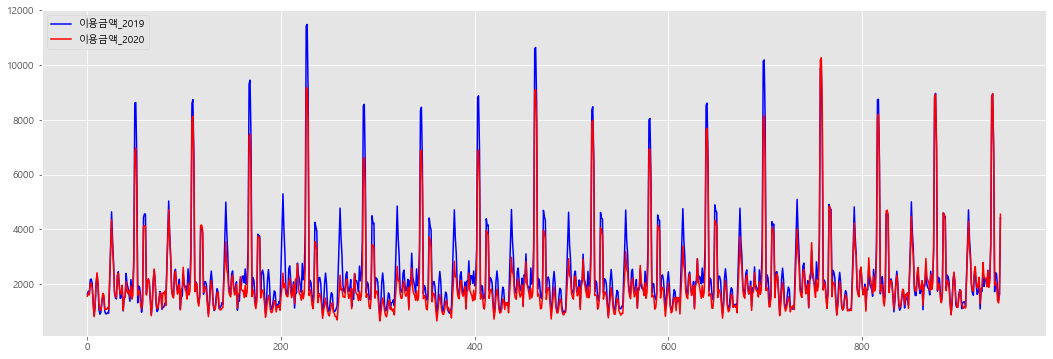

In [1197]:
card_index = get_index_table(card, "이용금액")
card_index.columns = ['주차', '시명', '구명', '행정동명', '이용금액_2019', '이용금액_2020']
get_MA_trend(card_index, '이용금액_2019', '이용금액_2020')

#### 유동인구의 이동평균 트랜드

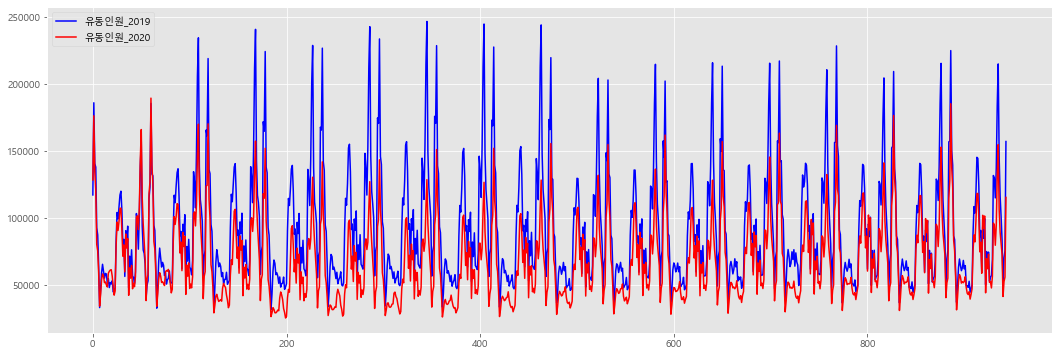

In [1198]:
sk_index = get_index_table(sk, '유동인원')
sk_index.columns = ['주차', '시명', '구명', '행정동명', '유동인원_2019', '유동인원_2020']
get_MA_trend(sk_index, '유동인원_2019', '유동인원_2020')

#### 물류건수의 이동평균 트랜드

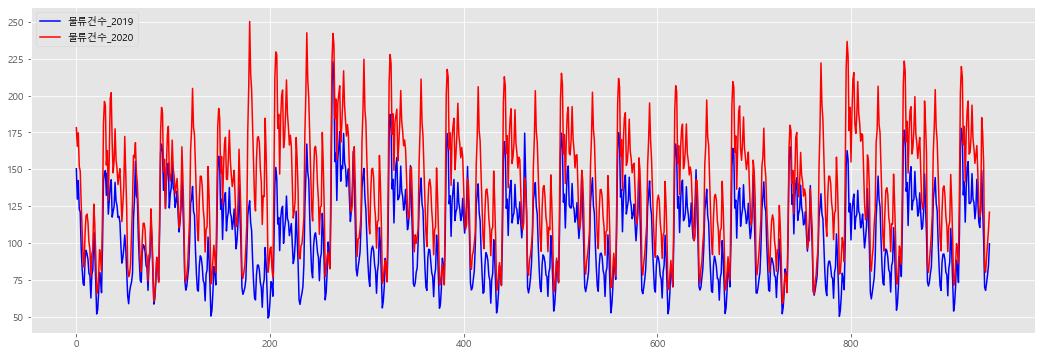

In [1199]:
cj_index = get_index_table(cj, "물류건수")
cj_index.columns = ['주차', '시명', '구명', '행정동명', '물류건수_2019', '물류건수_2020']
get_MA_trend(cj_index, '물류건수_2019', '물류건수_2020')

#### 유통매출지수의 이동평균 트랜드

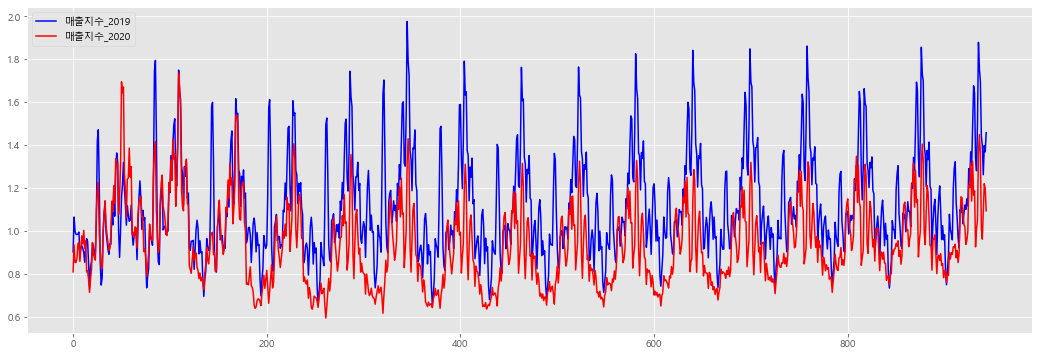

In [1200]:
gs_index = get_index_table(gs, "매출지수")
gs_index.columns = ['주차', '시명', '구명', '행정동명', '매출지수_2019', '매출지수_2020']
get_MA_trend(gs_index, '매출지수_2019', '매출지수_2020')

## 모든 데이터의 전반적인 트랜드는 정도의 차이만 있을뿐 비슷함을 확인

### 카드 매출 데이터

## 지출 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 지출지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [1201]:
card_index['지출지수'] = (card_index['이용금액_2020'] * 100) / card_index['이용금액_2019']

--> 2019년도와 2020년도의 카드매출 경향성은 비슷하다고 보여짐

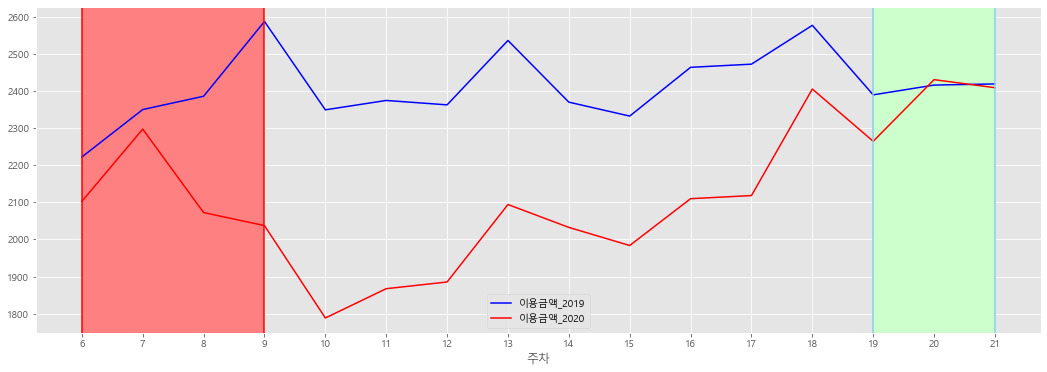

In [1202]:
get_week_trend(card_index, '이용금액_2019', '이용금액_2020')

> 6-9 주차의 매출은 하락한 반면

> 19-21주차에는 매출이 19년도의 그래프의 기울기와 다르게 상승한 모습

# 서울/대구 분리

In [1204]:
card_index_seoul = card_index[card_index['시명'] == '서울특별시']
card_index_daegu = card_index[card_index['시명'] == '대구광역시']

## 서울의 이용금액

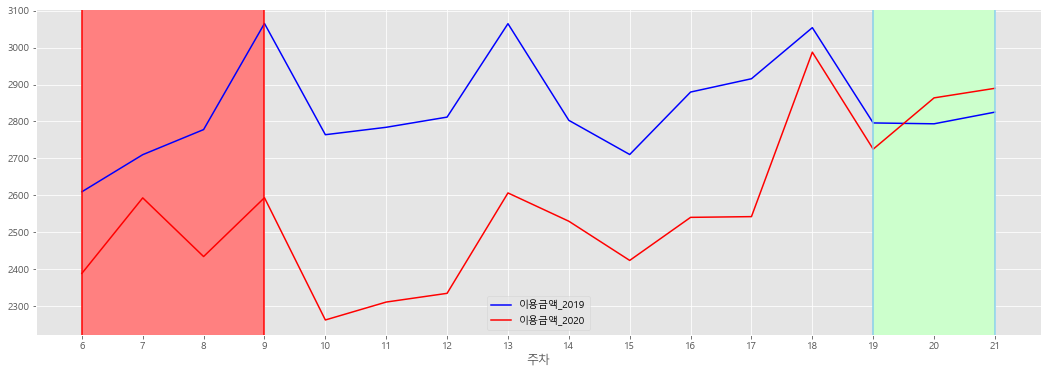

In [1205]:
get_week_trend(card_index_seoul, '이용금액_2019', '이용금액_2020')

## 대구의 이용금액

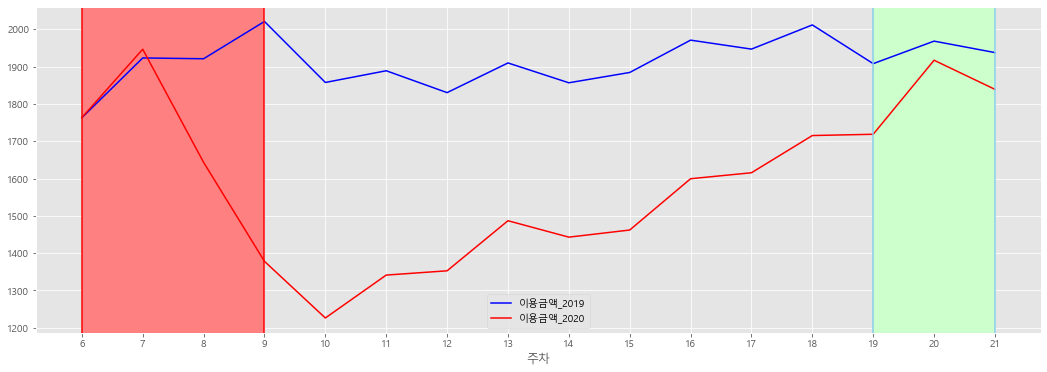

In [1206]:
get_week_trend(card_index_daegu, '이용금액_2019', '이용금액_2020')

--> 대구의 매출 감소가 더 두드러지는 모습

## 평균적인 지출 지수

In [1207]:
card_index['지출지수'].mean()

92.09546381379185

In [1208]:
card_index.groupby("시명")['지출지수'].mean()

시명
대구광역시    88.437754
서울특별시    95.181656
Name: 지출지수, dtype: float64

### 서울의 지출지수가 더 높음!

#### 전체 말고 보고싶은 6-9 주차의 지출만을 봐보자.

In [1209]:
card_index_sep = card_index[card_index['주차'].isin(range(6,10))]
card_index_sep_seoul = card_index_sep[card_index_sep['시명'] == '서울특별시']
card_index_sep_daegu = card_index_sep[card_index_sep['시명'] == '대구광역시']

In [1210]:
card_index_sep['지출지수'].mean()

95.43570971915658

In [1211]:
# 시별로 살펴보기
card_index_sep.groupby("시명")['지출지수'].mean()

시명
대구광역시    94.548035
서울특별시    96.184685
Name: 지출지수, dtype: float64

##### 마찬가지로 7-9 주차에 대구의 카드 매출이 더 낮음

## 서울/대구 구별로 살펴보기

In [1212]:
card_index_sep_seoul['지출지수'].mean()

96.18468512891702

In [1213]:
# 서울의 구별
card_index_sep_seoul.groupby("구명")['지출지수'].mean()

구명
노원구    99.778900
중구     91.563552
Name: 지출지수, dtype: float64

In [1214]:
card_index_sep_daegu['지출지수'].mean()

94.54803515944053

In [1215]:
# 대구의 구별
card_index_sep_daegu.groupby("구명")['지출지수'].mean()

구명
수성구    98.051573
중구     84.537926
Name: 지출지수, dtype: float64

대구의 경우 중구가 더 많은 매출 타격을 입음.

#### 동별로 살펴보기

In [1216]:
# 서울 구별로 나눈 데이터
card_index_sep_seoul_nowon = card_index_sep_seoul[card_index_sep_seoul['구명'] == '노원구']
card_index_sep_seoul_junggu = card_index_sep_seoul[card_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
card_index_sep_daegu_suseong = card_index_sep_daegu[card_index_sep_daegu['구명'] == '수성구']
card_index_sep_daegu_junggu = card_index_sep_daegu[card_index_sep_daegu['구명'] == '중구']

In [1217]:
card_index_sep_seoul_nowon['지출지수'].mean()

99.77889995332436

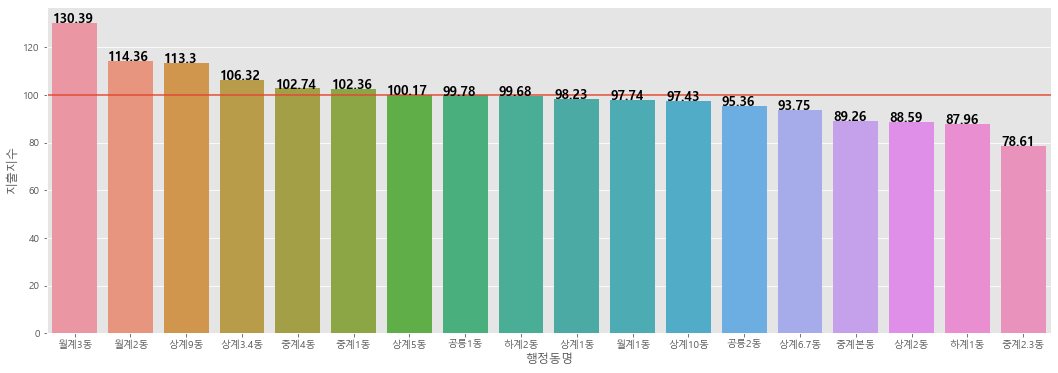

In [1218]:
# 서울노원구
nowon_index = card_index_sep_seoul_nowon.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '지출지수')

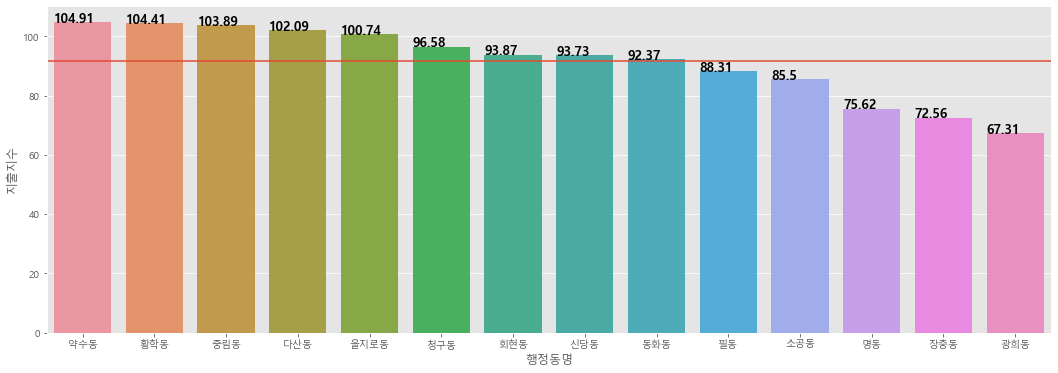

In [1219]:
# 서울중구
junggu_index = card_index_sep_seoul_junggu.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '지출지수')


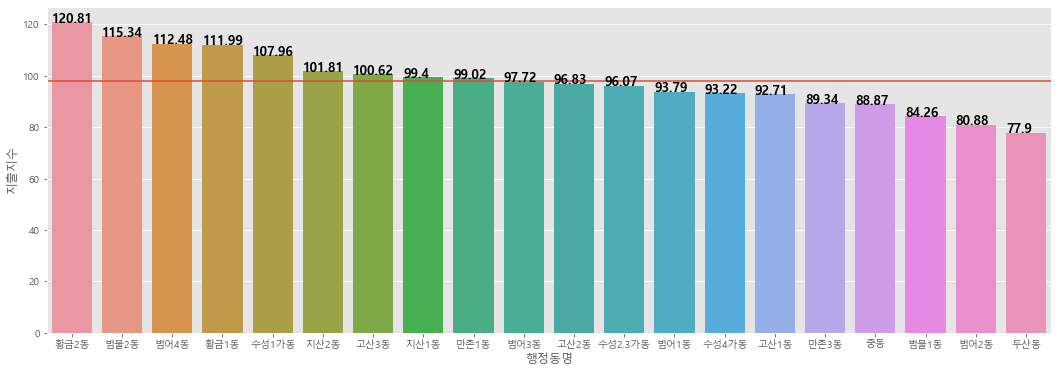

In [1220]:
# 대구수성구
suseong_index = card_index_sep_daegu_suseong.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '지출지수')


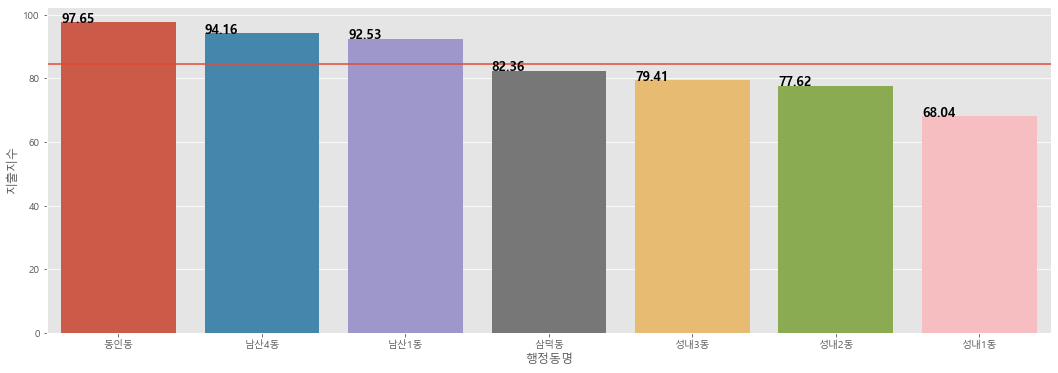

In [1221]:
# 대구중구
junggu_index = card_index_sep_daegu_junggu.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '지출지수')

### 유동인구 데이터

## 유동평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 유동지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [1222]:
sk_index['유동지수'] = (sk_index['유동인원_2020'] * 100) / sk_index['유동인원_2019']

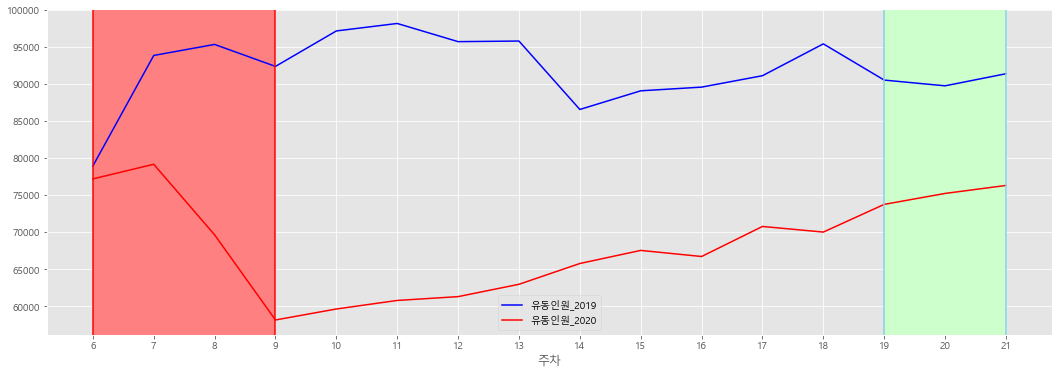

In [1223]:
get_week_trend(sk_index, '유동인원_2019', '유동인원_2020')

> 6-9 주차의 유동인구는 엄청 하락한 반면

> 19-21주차에는 유동인구가 다시 회복되는 모습

# 서울/대구 분리

In [1224]:
sk_index_seoul = sk_index[sk_index['시명'] == '서울특별시']
sk_index_daegu = sk_index[sk_index['시명'] == '대구광역시']

## 서울의 유동인구

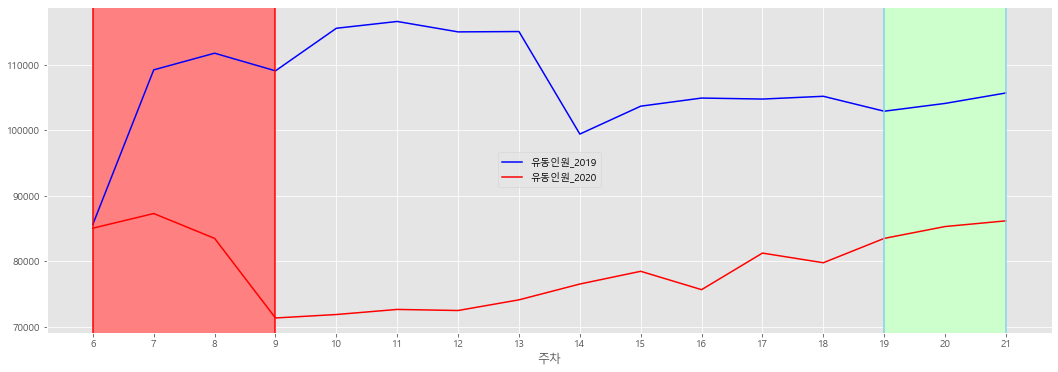

In [1225]:
get_week_trend(sk_index_seoul, '유동인원_2019', '유동인원_2020')

## 대구의 유동인구

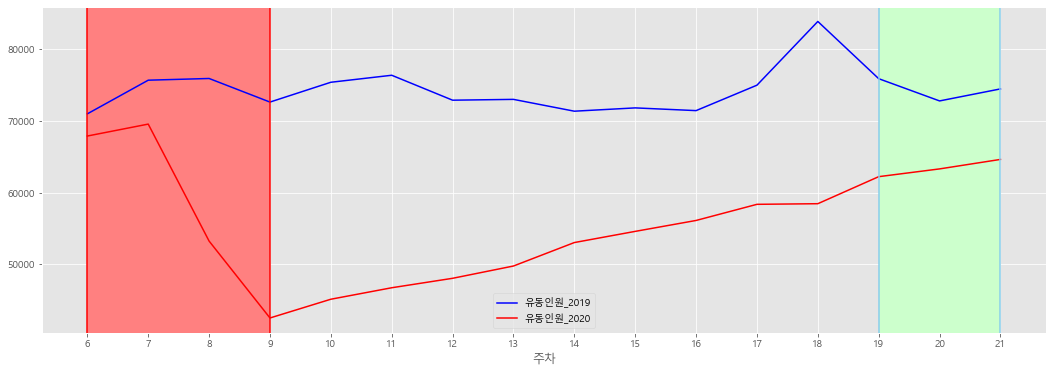

In [1226]:
get_week_trend(sk_index_daegu, '유동인원_2019', '유동인원_2020')

--> 대구의 유동인구 감소가 더 두드러지는 모습

## 평균적인 유동인구 지수

In [1227]:
sk_index['유동지수'].mean()

78.51803737330097

In [1228]:
sk_index.groupby("시명")['유동지수'].mean()

시명
대구광역시    77.327346
서울특별시    79.522683
Name: 유동지수, dtype: float64

### 확실히 대구가 더 낮아진 모습

#### 전체 말고 보고싶은 6-9 주차의 유동인구만을 봐보자.

In [1229]:
sk_index_sep = sk_index[sk_index['주차'].isin(range(6,10))]
sk_index_sep_seoul = sk_index_sep[sk_index_sep['시명'] == '서울특별시']
sk_index_sep_daegu = sk_index_sep[sk_index_sep['시명'] == '대구광역시']

In [1230]:
sk_index_sep['유동지수'].mean()

83.86966183658366

In [1231]:
sk_index_sep['유동지수'].mean()

83.86966183658366

In [1232]:
# 시별로 살펴보기
sk_index_sep.groupby("시명")['유동지수'].mean()

시명
대구광역시    82.754935
서울특별시    84.810212
Name: 유동지수, dtype: float64

##### 마찬가지로 6-9 주차에 대구의 유동인구 지수가 더 낮음

## 서울/대구 구별로 살펴보기

In [1233]:
sk_index_sep_seoul['유동지수'].mean()

84.8102124119408

In [1234]:
# 서울의 구별
sk_index_sep_seoul.groupby("구명")['유동지수'].mean()

구명
노원구    82.716305
중구     87.502379
Name: 유동지수, dtype: float64

지출지수의 총 량 : 78.90508082515937 인데 비해

노원구가 79.577854으로 더 유동인구가 많고 중구는 작년도에 비해 타격을 엄청 봄

In [1235]:
sk_index_sep_daegu['유동지수'].mean()

82.75493522875286

In [1236]:
# 대구의 구별
sk_index_sep_daegu.groupby("구명")['유동지수'].mean()

구명
수성구    85.350257
중구     75.339729
Name: 유동지수, dtype: float64

대구의 경우 중구가 더 많은 유동인구 감소

#### 동별로 살펴보기

In [1237]:
# 서울 구별로 나눈 데이터
sk_index_sep_seoul_nowon = sk_index_sep_seoul[sk_index_sep_seoul['구명'] == '노원구']
sk_index_sep_seoul_junggu = sk_index_sep_seoul[sk_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
sk_index_sep_daegu_suseong = sk_index_sep_daegu[sk_index_sep_daegu['구명'] == '수성구']
sk_index_sep_daegu_junggu = sk_index_sep_daegu[sk_index_sep_daegu['구명'] == '중구']

In [1238]:
sk_index_sep_seoul_nowon['유동지수'].mean()

82.7163051244995

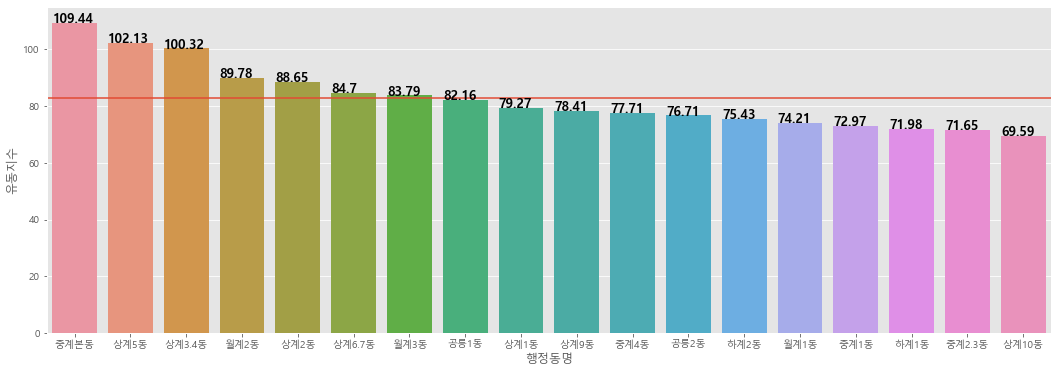

In [1239]:
# 서울노원구
nowon_index = sk_index_sep_seoul_nowon.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '유동지수')

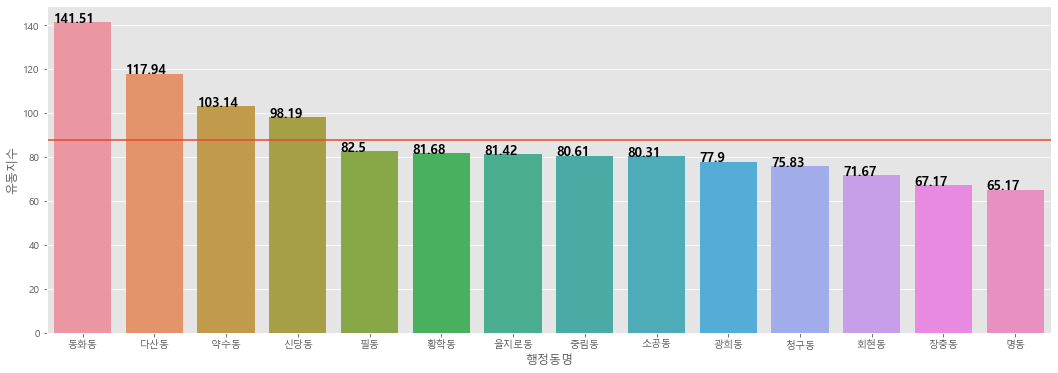

In [1240]:
# 서울중구
junggu_index = sk_index_sep_seoul_junggu.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유동지수')

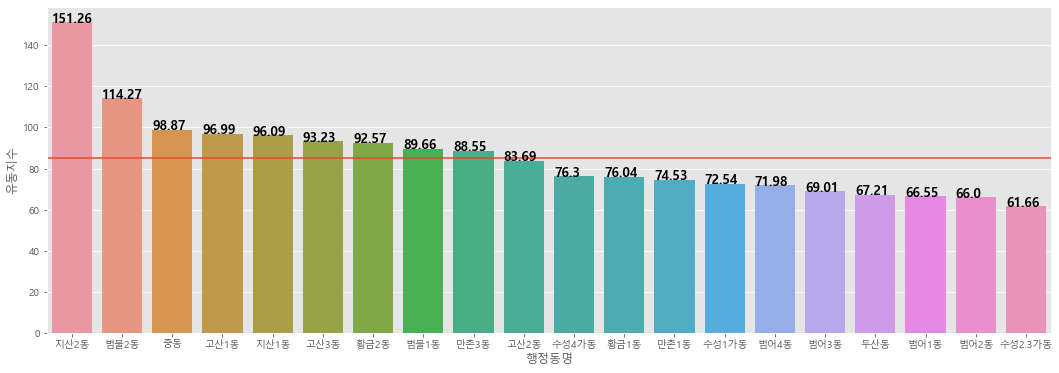

In [1241]:
# 대구수성구
suseong_index = sk_index_sep_daegu_suseong.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '유동지수')

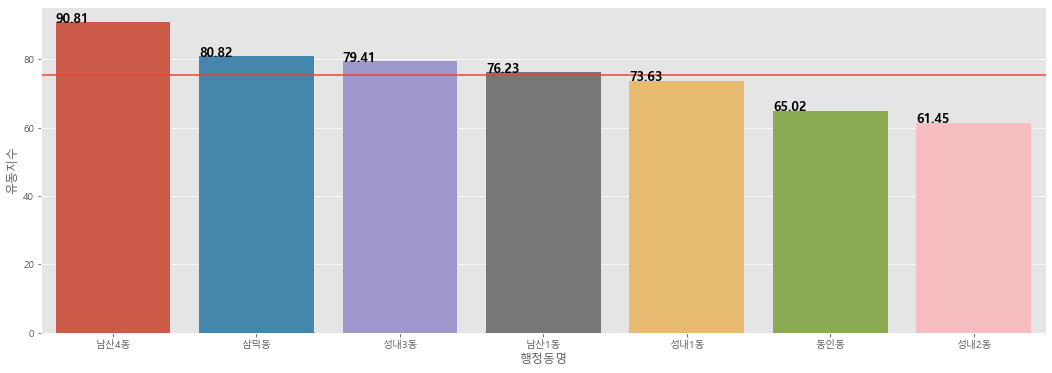

In [1242]:
# 대구중구
junggu_index = sk_index_sep_daegu_junggu.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유동지수')

### cj(물류) 데이터

## 물류평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 물류지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [1243]:
cj_index['물류지수'] = (cj_index['물류건수_2020'] * 100) / cj_index['물류건수_2019']

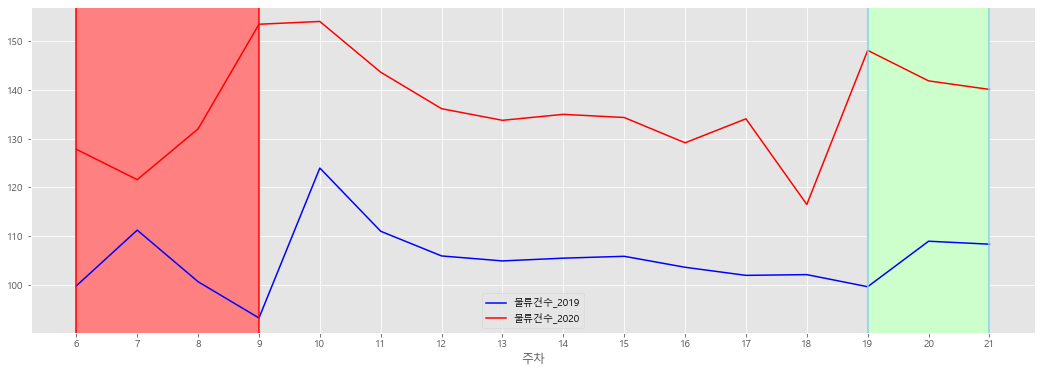

In [1244]:
get_week_trend(cj_index, '물류건수_2019', '물류건수_2020')

> 2019년에도에 비해 물류는 상당히 오른 모습.

# 서울/대구 분리

In [1245]:
cj_index_seoul = cj_index[cj_index['시명'] == '서울특별시']
cj_index_daegu = cj_index[cj_index['시명'] == '대구광역시']

## 서울의 물류건수부터 보기

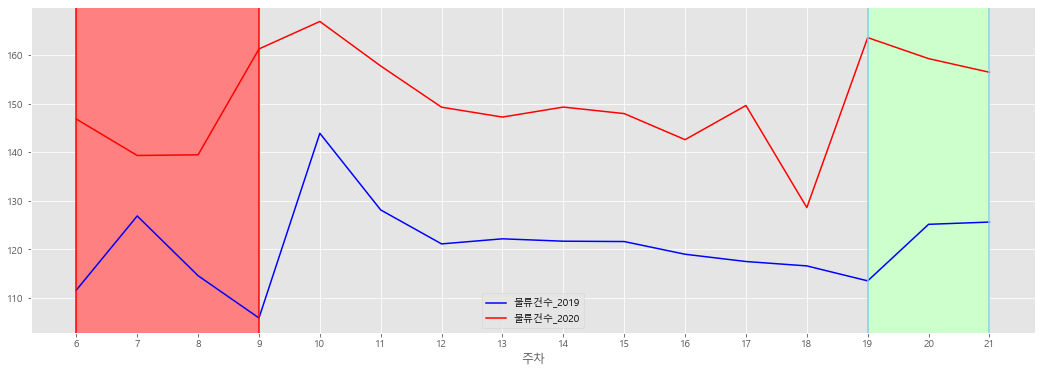

In [1246]:
get_week_trend(cj_index_seoul, '물류건수_2019', '물류건수_2020')

## 대구의 물류건수 보기

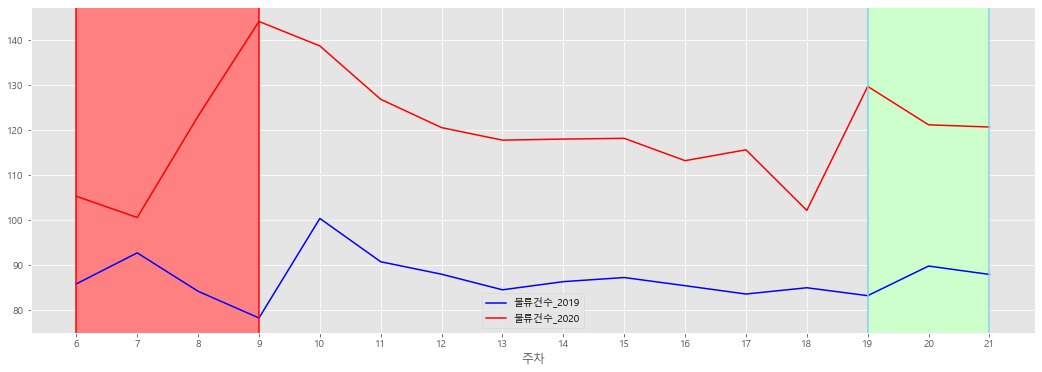

In [1247]:
get_week_trend(cj_index_daegu, '물류건수_2019', '물류건수_2020')

--> 전반적으로 물류 지수가 더 상승했지만 대구의 물류가 더 상승함

## 평균적인 물류 지수

In [1248]:
cj_index['물류지수'].mean()

130.6899512689318

In [1249]:
cj_index.groupby("시명")['물류지수'].mean()

시명
대구광역시    137.309749
서울특별시    125.104497
Name: 물류지수, dtype: float64

### 확실히 대구의 물류가 더 많이 상승한 모습

#### 전체 말고 보고싶은 7-9 주차의 물류만을 봐보자.

In [1250]:
cj_index_sep = cj_index[cj_index['주차'].isin(range(6,10))]
cj_index_sep_seoul = cj_index_sep[cj_index_sep['시명'] == '서울특별시']
cj_index_sep_daegu = cj_index_sep[cj_index_sep['시명'] == '대구광역시']

In [1251]:
cj_index_sep['물류지수'].mean()

134.2039280512528

In [1252]:
# 시별로 살펴보기
cj_index_sep.groupby("시명")['물류지수'].mean()

시명
대구광역시    139.944699
서울특별시    129.360152
Name: 물류지수, dtype: float64

##### 마찬가지로 7-9 주차에 대구의 물류지수가 더 높은모습

## 서울/대구 구별로 살펴보기

In [1253]:
cj_index_sep_seoul['물류지수'].mean()

129.36015221326605

In [1254]:
# 서울의 구별
cj_index_sep_seoul.groupby("구명")['물류지수'].mean()

구명
노원구    130.628542
중구     127.729365
Name: 물류지수, dtype: float64

지출지수의 총 량 : 129.03900666521807 인데 비해

노원구가 132.384006으로 더 물류가 많고 중구는 상승했으나 평균에 못미치는모습

In [1255]:
cj_index_sep_daegu['물류지수'].mean()

139.94469941479252

In [1256]:
# 대구의 구별
cj_index_sep_daegu.groupby("구명")['물류지수'].mean()

구명
수성구    144.927541
중구     125.708010
Name: 물류지수, dtype: float64

대구의 경우 수성구의 물류지수가 엄청 상승한 모습.

#### 동별로 살펴보기

In [1257]:
# 서울 구별로 나눈 데이터
cj_index_sep_seoul_nowon = cj_index_sep_seoul[cj_index_sep_seoul['구명'] == '노원구']
cj_index_sep_seoul_junggu = cj_index_sep_seoul[cj_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
cj_index_sep_daegu_suseong = cj_index_sep_daegu[cj_index_sep_daegu['구명'] == '수성구']
cj_index_sep_daegu_junggu = cj_index_sep_daegu[cj_index_sep_daegu['구명'] == '중구']

In [1258]:
cj_index_sep_seoul_nowon['물류지수'].mean()

130.62854225660956

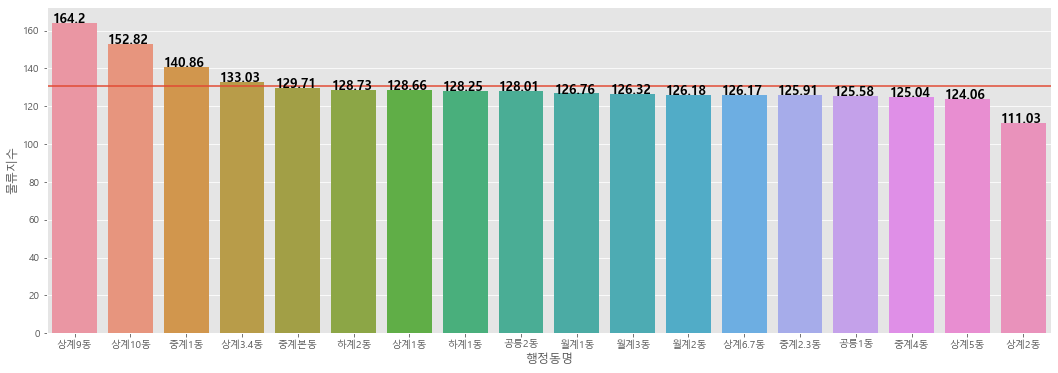

In [1259]:
# 서울노원구
nowon_index = cj_index_sep_seoul_nowon.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '물류지수')

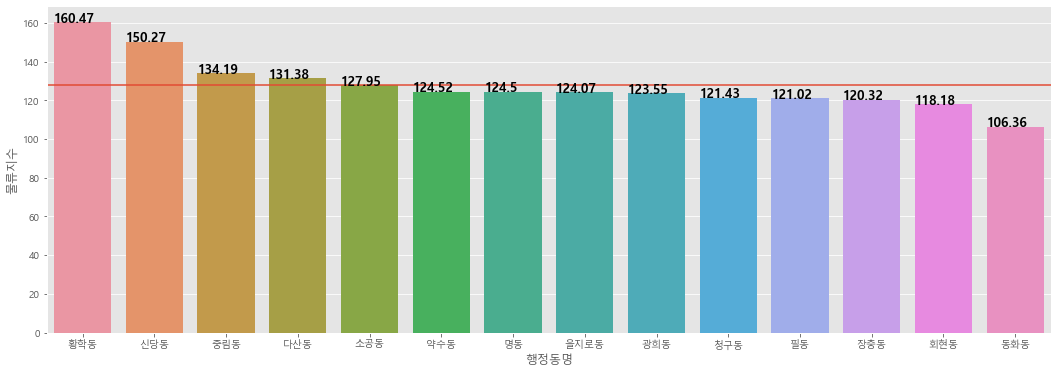

In [1260]:
# 서울중구
junggu_index = cj_index_sep_seoul_junggu.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '물류지수')

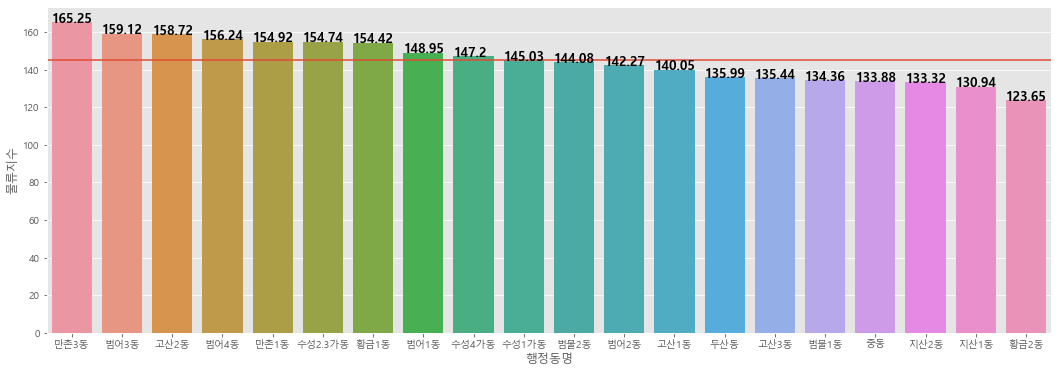

In [1261]:
# 대구수성구
suseong_index = cj_index_sep_daegu_suseong.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '중구', '물류지수')

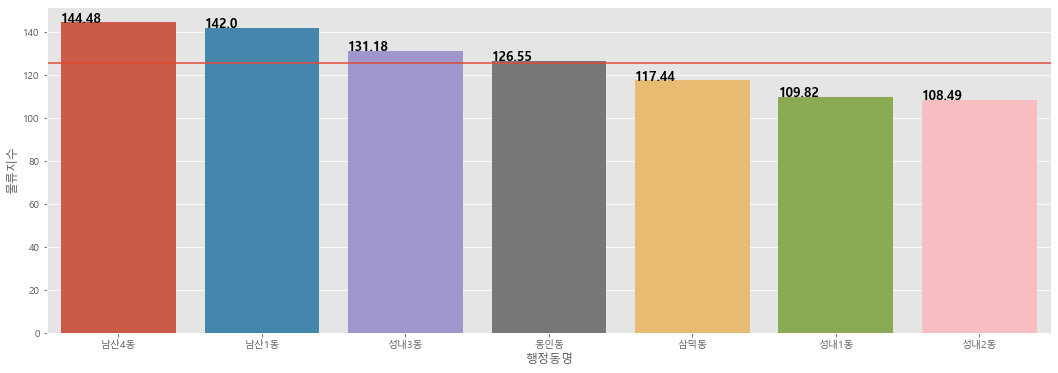

In [1262]:
# 대구중구
junggu_index = cj_index_sep_daegu_junggu.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '물류지수')

### gs(유통) 데이터

## 유통평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 유통지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [1263]:
gs_index

,주차,시명,구명,행정동명,매출지수_2019,매출지수_2020
0,6,대구광역시,수성구,고산1동,0.901431,0.808182
1,6,대구광역시,수성구,고산2동,1.227240,1.060018
2,6,대구광역시,수성구,고산3동,0.863516,0.689846
3,6,대구광역시,수성구,두산동,0.860384,0.806857
4,6,대구광역시,수성구,만촌1동,1.224276,1.120403
...,...,...,...,...,...,...
939,21,서울특별시,중구,중림동,1.233220,1.193632
940,21,서울특별시,중구,청구동,1.429569,1.369279
941,21,서울특별시,중구,필동,1.530478,1.095994
942,21,서울특별시,중구,황학동,1.144587,1.124605


In [1264]:
gs_index['유통지수'] = (gs_index['매출지수_2020'] * 100) / gs_index['매출지수_2019']

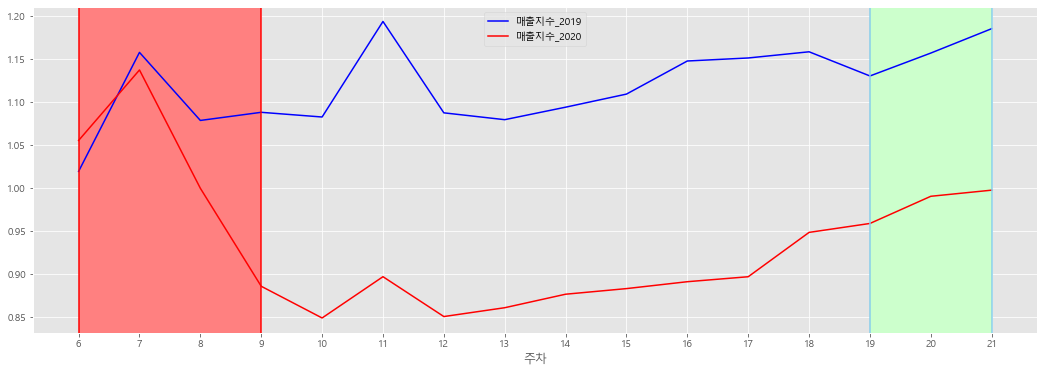

In [1265]:
get_week_trend(gs_index, '매출지수_2019', '매출지수_2020')

> 2019년에도에 비해 유통이 많이 하락함

# 서울/대구 분리

In [1266]:
gs_index_seoul = gs_index[cj_index['시명'] == '서울특별시']
gs_index_daegu = gs_index[cj_index['시명'] == '대구광역시']

## 서울의 유통부터 보기

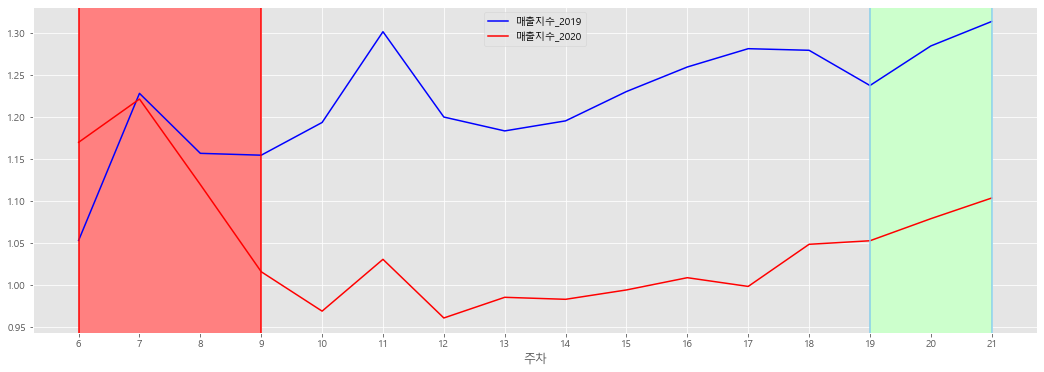

In [1267]:
get_week_trend(gs_index_seoul, '매출지수_2019', '매출지수_2020')

## 대구의 유통 보기

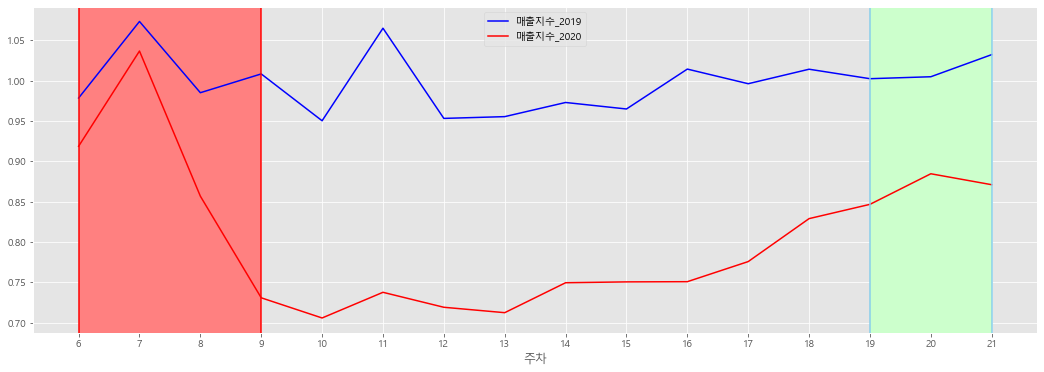

In [1269]:
get_week_trend(gs_index_daegu, '매출지수_2019', '매출지수_2020')

--> 전반적으로 유통이 많이 하락했지만 대구의 유통이 더 두드러지게 하락함

## 평균적인 유통 지수

In [1270]:
gs_index['유통지수'].mean()

86.57443110024181

In [1271]:
gs_index.groupby("시명")['유통지수'].mean()

시명
대구광역시    83.566630
서울특별시    89.112263
Name: 유통지수, dtype: float64

### 확실히 대구의 유통이 더 많이 감소한 모습

#### 전체 말고 보고싶은 7-9 주차의 유통만을 봐보자.

In [1272]:
gs_index_sep = gs_index[gs_index['주차'].isin(range(6,10))]
gs_index_sep_seoul = gs_index_sep[gs_index_sep['시명'] == '서울특별시']
gs_index_sep_daegu = gs_index_sep[gs_index_sep['시명'] == '대구광역시']

In [1273]:
gs_index_sep['유통지수'].mean()

95.97850343740483

In [1274]:
# 시별로 살펴보기
gs_index_sep.groupby("시명")['유통지수'].mean()

시명
대구광역시     90.582282
서울특별시    100.531566
Name: 유통지수, dtype: float64

##### 마찬가지로 7-9 주차에 대구의 유통지수가 더 낮은 모습

## 서울/대구 구별로 살펴보기

In [1275]:
gs_index_sep_seoul['유통지수'].mean()

100.53156553199722

In [1276]:
# 서울의 구별
gs_index_sep_seoul.groupby("구명")['유통지수'].mean()

구명
노원구    100.519591
중구     100.546961
Name: 유통지수, dtype: float64

지출지수의 총 량 : 96.54713341003941 인데 비해

노원구가 99.225466으로 더 유통이 많고 중구는 더 타격을 많이 봄

In [1277]:
gs_index_sep_daegu['유통지수'].mean()

90.58228169566584

In [1278]:
# 대구의 구별
gs_index_sep_daegu.groupby("구명")['유통지수'].mean()

구명
수성구    92.371285
중구     85.470844
Name: 유통지수, dtype: float64

대구의 경우 중구의 유통이 더 많이 감소한 모습

#### 동별로 살펴보기

In [1279]:
# 서울 구별로 나눈 데이터
gs_index_sep_seoul_nowon = gs_index_sep_seoul[gs_index_sep_seoul['구명'] == '노원구']
gs_index_sep_seoul_junggu = gs_index_sep_seoul[gs_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
gs_index_sep_daegu_suseong = gs_index_sep_daegu[gs_index_sep_daegu['구명'] == '수성구']
gs_index_sep_daegu_junggu = gs_index_sep_daegu[gs_index_sep_daegu['구명'] == '중구']

In [1280]:
gs_index_sep_seoul_nowon['유통지수'].mean()

100.51959100794893

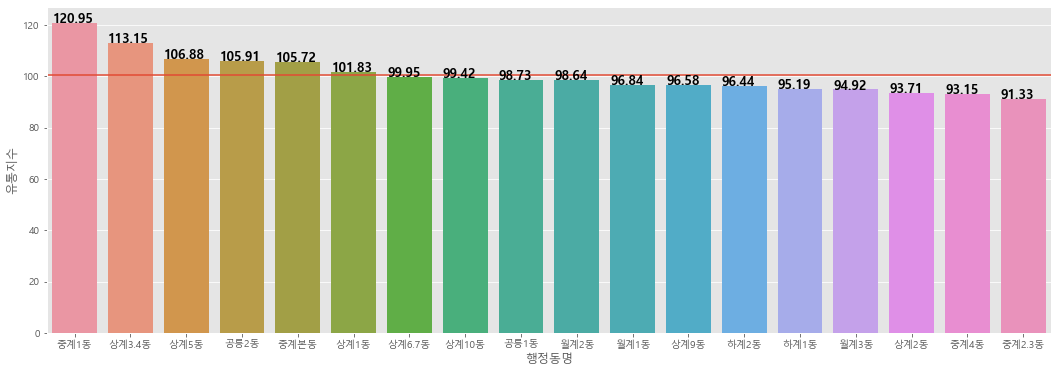

In [1281]:
# 서울노원구
nowon_index = gs_index_sep_seoul_nowon.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '유통지수')

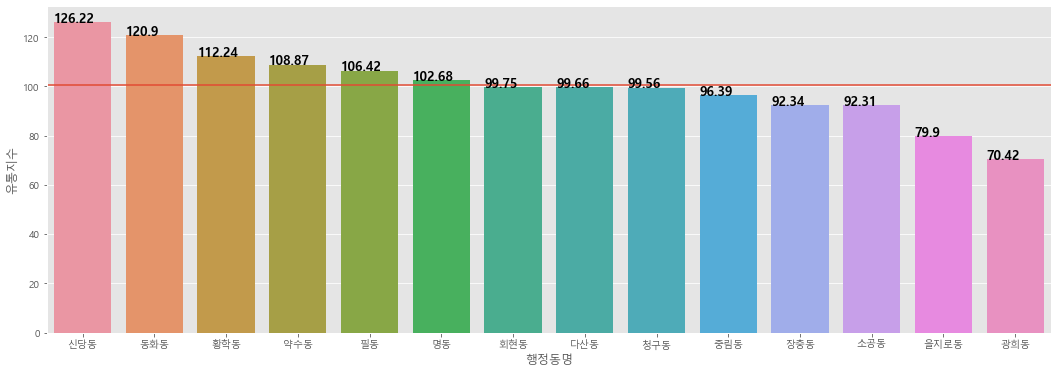

In [1282]:
# 서울중구
junggu_index = gs_index_sep_seoul_junggu.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유통지수')

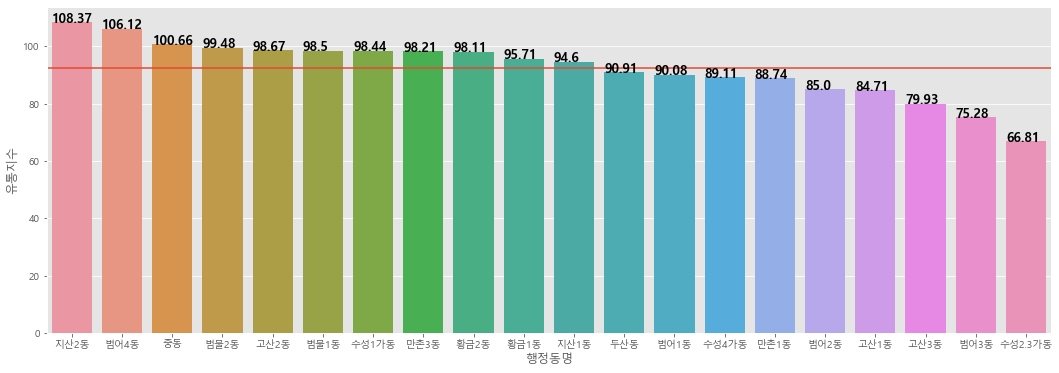

In [1283]:
# 대구수성구
suseong_index = gs_index_sep_daegu_suseong.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '유통지수')

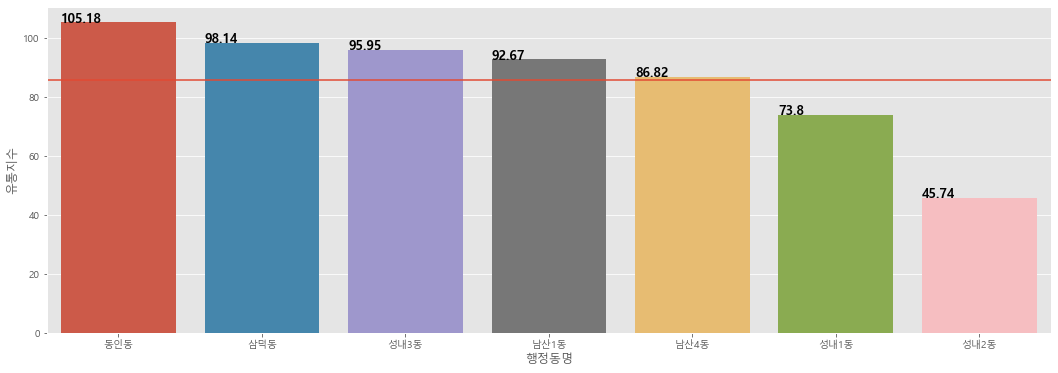

In [1284]:
# 대구중구
junggu_index = gs_index_sep_daegu_junggu.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유통지수')

### 위 4개의 지수를 바탕으로 집단을 나누고자 함

In [1285]:
# fig = plt.figure(figsize=(18, 12))

# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)
# ax4 = fig.add_subplot(2,2,4)

# ax1.plot(card_index['금액평균_2019'], color='blue')
# ax1.plot(card_index['금액평균_2020'], color='red')
# ax1.legend(['2019 금액 이동평균', '2020 금액 이동평균'], loc='upper left')

# ax2.plot(sk_index['유동평균_2019'], color='blue')
# ax2.plot(sk_index['유동평균_2020'], color='red')
# ax2.legend(['2019 유동평균', '2020 유동평균'])

# ax3.plot(cj_index['물류평균_2019'], color='blue')
# ax3.plot(cj_index['물류평균_2020'], color='red')
# ax3.legend(['2019 물류평균', '2020 물류평균'])


# ax4.plot(gs_index['유통평균_2019'], color='blue')
# ax4.plot(gs_index['유통평균_2020'], color='red')
# ax4.legend(['2019 유통평균', '2020 유통평균'], loc='upper left')

In [1286]:
index_group_cj = cj_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='물류지수', aggfunc='mean').reset_index()
index_group_sk = sk_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='유동지수', aggfunc='mean').reset_index()
index_group_gs = gs_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='유통지수', aggfunc='mean').reset_index()
index_group_card = card_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='지출지수', aggfunc='mean').reset_index()

index_group = index_group_sk.merge(index_group_cj, how='inner', on=['시명','구명','행정동명'])
index_group = index_group.merge(index_group_gs, how='inner', on =['시명','구명','행정동명'])
index_group = index_group.merge(index_group_card, how='inner', on =['시명','구명','행정동명'])

# 지수 group table 생성
index_group

,시명,구명,행정동명,유동지수,물류지수,유통지수,지출지수
0,대구광역시,수성구,고산1동,96.993125,140.045057,84.706518,92.713090
1,대구광역시,수성구,고산2동,83.690071,158.723424,98.668659,96.834632
2,대구광역시,수성구,고산3동,93.226096,135.439608,79.930011,100.615960
3,대구광역시,수성구,두산동,67.210814,135.989467,90.908885,77.900330
4,대구광역시,수성구,만촌1동,74.534933,154.923628,88.736492,99.019444
5,대구광역시,수성구,만촌3동,88.547928,165.247663,98.205493,89.336375
6,대구광역시,수성구,범물1동,89.657903,134.361052,98.498040,84.259059
7,대구광역시,수성구,범물2동,114.268435,144.075046,99.484493,115.336661
8,대구광역시,수성구,범어1동,66.553903,148.945957,90.076930,93.794887
9,대구광역시,수성구,범어2동,65.999768,142.267358,84.997924,80.883809


In [1287]:
# 각 데이터의 척도를 맞추기위해 MinMax Scaling 진행
index_group['유동지수'] = get_scaled(index_group, '유동지수')
index_group['물류지수'] = get_scaled(index_group, '물류지수')
index_group['유통지수'] = get_scaled(index_group, '유통지수')
index_group['지출지수'] = get_scaled(index_group, '지출지수')

In [1288]:
data = index_group.set_index(['시명', '구명', '행정동명'])

In [1289]:
# PCA를 이용해 데이터의 분산을 잘 설명해줄 수 있는 주성분 2개를 찾음
from sklearn.decomposition import PCA

pca = PCA(2, random_state=1015)
data_pca = pca.fit_transform(data)

data = pd.DataFrame(data_pca, columns = ['pc1', 'pc2'])
print(f"분산 설명 :{pca.explained_variance_ratio_}")

분산 설명 :[0.42711505 0.33903723]


In [1290]:
(pca.explained_variance_ratio_).sum()

0.7661522760240519

### 데이터 변동의 약 80%를 설명해주는 모습

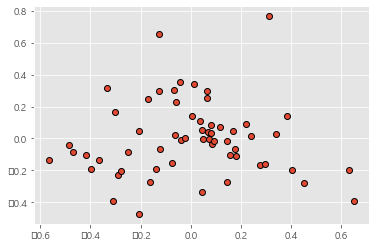

In [1291]:
plt.scatter(data['pc1'], data['pc2'], linewidth=1, edgecolor='black')

plt.show()

In [1292]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_n = 1
best_score = -1

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, random_state=1015)
    kmeans.fit(data)
    cluster = kmeans.predict(data)
    score = silhouette_score(data, cluster)
    
    print('클러스터의 수 : {}, 실루엣 점수 : {:.3f}'.format(n_cluster, score))
    if score > best_score :
        best_n = n_cluster
        best_score = score
        
print('\n가장 높은 실루엣 점수를 가진 클러스터 수 : {}, 실루엣 점수 : {:.3f}'.format(best_n, best_score))

클러스터의 수 : 2, 실루엣 점수 : 0.385
클러스터의 수 : 3, 실루엣 점수 : 0.424
클러스터의 수 : 4, 실루엣 점수 : 0.414
클러스터의 수 : 5, 실루엣 점수 : 0.402
클러스터의 수 : 6, 실루엣 점수 : 0.396
클러스터의 수 : 7, 실루엣 점수 : 0.363
클러스터의 수 : 8, 실루엣 점수 : 0.341
클러스터의 수 : 9, 실루엣 점수 : 0.358
클러스터의 수 : 10, 실루엣 점수 : 0.386

가장 높은 실루엣 점수를 가진 클러스터 수 : 3, 실루엣 점수 : 0.424


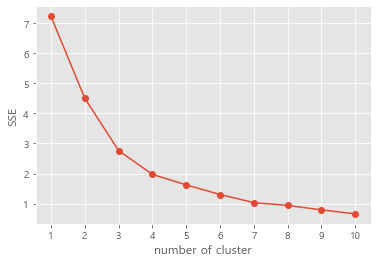

In [1293]:
elbow(data)

In [1294]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1015)

kmeans.fit(data)

cluster = kmeans.predict(data)

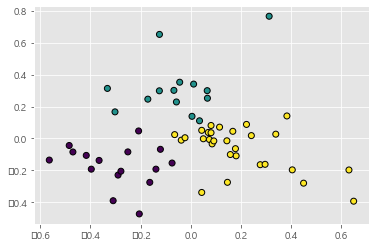

In [1295]:
plt.scatter(data['pc1'], data['pc2'], c=cluster, linewidth=1, edgecolor='black')

plt.show()
plt.style.use('ggplot')

In [1296]:
# pca를 통해 나눈 군집을 원래 데이터에 추가
index_group['그룹'] = cluster

In [1297]:
index_group.groupby('그룹').count()

,시명,구명,행정동명,유동지수,물류지수,유통지수,지출지수
그룹,,,,,,,
0,16,16,16,16,16,16,16
1,14,14,14,14,14,14,14
2,29,29,29,29,29,29,29


In [1298]:
df = index_group.groupby("그룹")['물류지수', '유통지수', '유동지수', '지출지수'].mean()

In [1299]:
# 나뉜 집단간의 상관계수 
df.corr()

,물류지수,유통지수,유동지수,지출지수
물류지수,1.000000,-0.203849,-0.416045,0.393623
유통지수,-0.203849,1.000000,0.975060,0.819730
유동지수,-0.416045,0.975060,1.000000,0.672170
지출지수,0.393623,0.819730,0.672170,1.000000


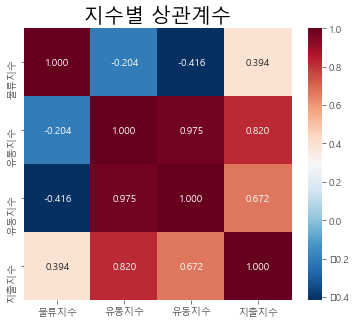

In [1300]:
fig, ax = plt.subplots( figsize = (6, 5))
plt.title('지수별 상관계수', fontsize=20)
sns.heatmap(df.corr(), cmap='RdBu_r', annot = True, fmt='.3f')

### -> 유통, 유동, 카드지수가 강한 양의 상관관계를 갖고있음.

#### 이를 바탕으로 유동인구가 유통의 매출지수와 카드매출에 강한 연관성을 갖고있음을 알 수 있다.

#### out 지표 : 유동인구, 유통, 카드매출
#### in 지표 : 물류

Text(0.5, 1.0, 'In_index')

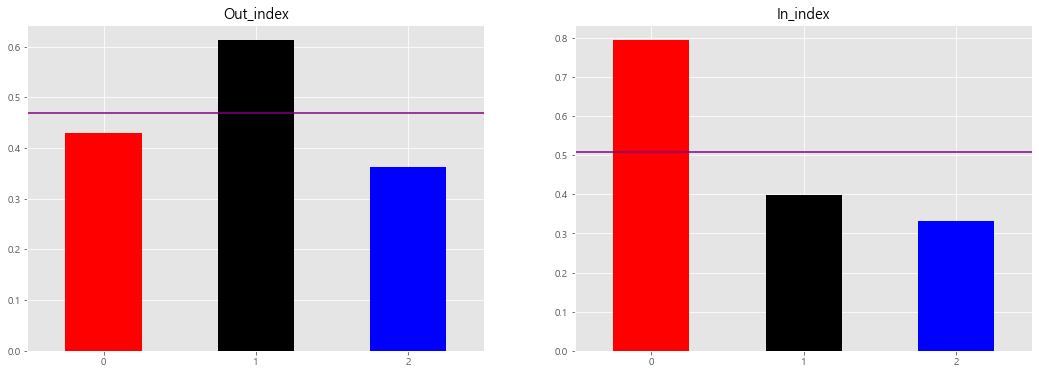

In [1301]:
# out지표와 in 지표를 만들어내 그룹의 특성 분류
df['out_index'] = df[['유통지수', '지출지수','유동지수']].mean(axis=1)
df['in_index'] = df['물류지수']
df.reset_index(inplace=True)

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(1, 2,1)
ax1 = df['out_index'].plot(kind='bar', color = ['red','black','blue'], rot=0)
ax1.axhline(df['out_index'].mean(), color='purple')
ax1.set_title('Out_index')

ax2 = fig.add_subplot(1,2,2)

ax2 = df['in_index'].plot(kind='bar', color = ['red','black','blue'], rot=0)
ax2.axhline(df['in_index'].mean(), color='purple')
ax2.set_title('In_index')

# ax2.plot(df['그룹'], df['in_index'], kind='bar', color = ['red','black','blue'], rot=0)

## 정리

#### 0번 군집의 성향 : in 지표가 높다 -> 물류를 많이 시키는 지역

#### 1번 군집의 성향 : out 지표가 높다 -> 사람들 많이 돌아다니는 지역

#### 2번 군집의 성향 : Out, In 지표 모두 낮은 지역

In [1302]:
# 시/구/동 별 그룹을 담고있는 테이블
group_dic = {
    0 : 'in',
    1 : 'out',
    2 : 'abnormal'
}
cluster_table = index_group[['시명', '구명','행정동명', '그룹']]
cluster_table['그룹'] = cluster_table['그룹'].map(group_dic)

# 이제 카드매출의 19~21주차 보자!

In [1303]:
card_index_line = get_line_index_table(card, '이용금액')
card_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '이용금액_2019', '이용금액_2020']

card_index_line_sep = card_index_line[card_index_line['주차'].isin(range(19,22))]

card_index_line_sep = card_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

card_index_line_sep

,주차,시명,구명,행정동명,업종명,이용금액_2019,이용금액_2020,그룹
0,19,대구광역시,수성구,고산1동,광학제품,519,7424,abnormal
1,19,대구광역시,수성구,고산1동,레저업소,62573,61123,abnormal
2,19,대구광역시,수성구,고산1동,레저용품,65614,53227,abnormal
3,19,대구광역시,수성구,고산1동,문화취미,12399,10420,abnormal
4,19,대구광역시,수성구,고산1동,보건위생,120393,70517,abnormal
...,...,...,...,...,...,...,...,...
3089,21,서울특별시,중구,회현동,의복,516160,706545,abnormal
3090,21,서울특별시,중구,회현동,자동차정비,91963,91635,abnormal
3091,21,서울특별시,중구,회현동,자동차판매,349,2017,abnormal
3092,21,서울특별시,중구,회현동,주방용구,78570,171710,abnormal


#### 아까와 마찬가지로 소비지수 생성

In [1304]:
# 카드소비지수 생성
# 2019년의 동주차 이용 금액을 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 판매가 변화했는지 지수로 산출
card_index_line_sep['카드소비지수'] = (card_index_line_sep['이용금액_2020']  * 100) / card_index_line_sep['이용금액_2019']
# card_index_line_sep['카드소비지수'] = get_scaled(card_index_line_sep, '카드소비지수')

## 19-21주차의 전반적인 경향

In [1305]:
df = card_index_line_sep.pivot_table(index='업종명', values='카드소비지수', aggfunc='mean').reset_index()

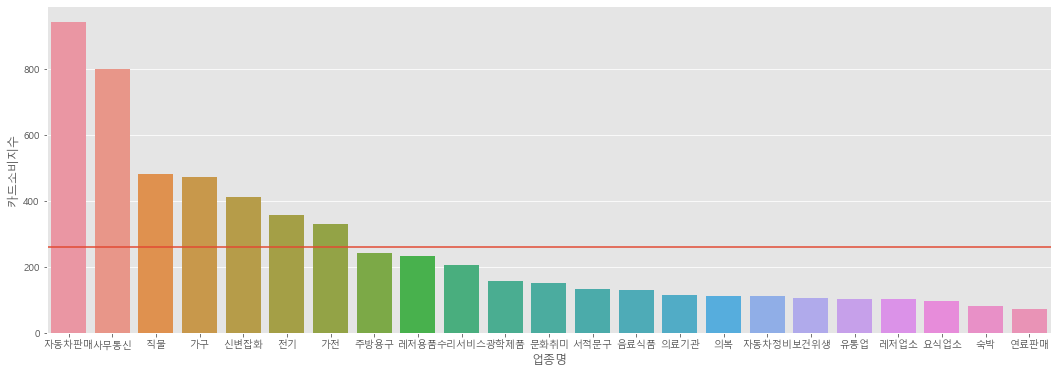

In [1306]:
get_plot_by_line(df, "카드소비지수")

### 나눈 지역별로 보기

In [1307]:
df_cluster = card_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '카드소비지수', aggfunc='mean').reset_index()

### 1. In (물류지수가 높은 지역)

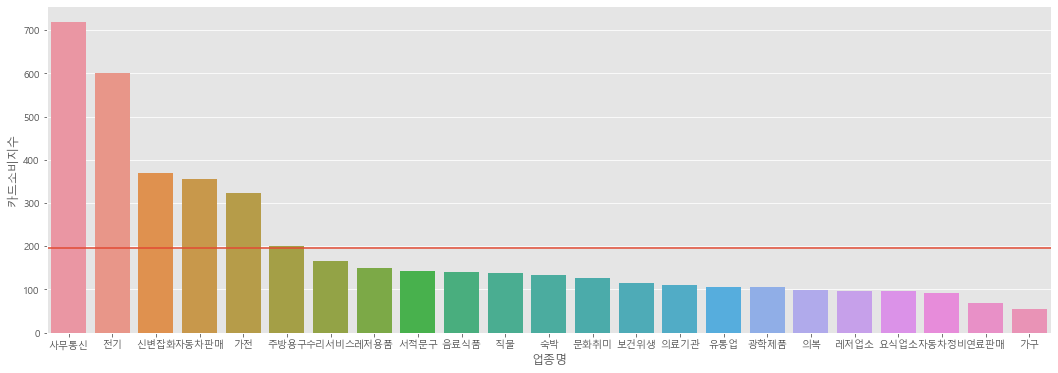

In [1308]:
df_cluster_in = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_in.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_in, '카드소비지수')

### 2. Out (외출 지수가 높은 지역)

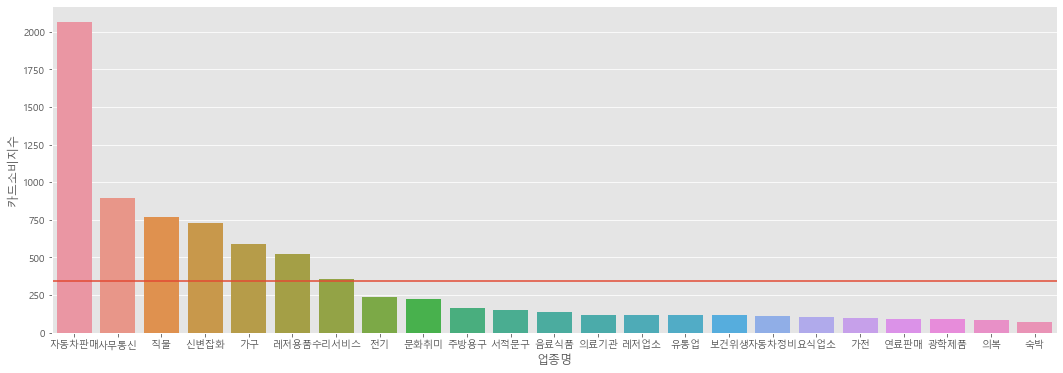

In [1309]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '카드소비지수')

### 3. abnormal (이상한 애들)

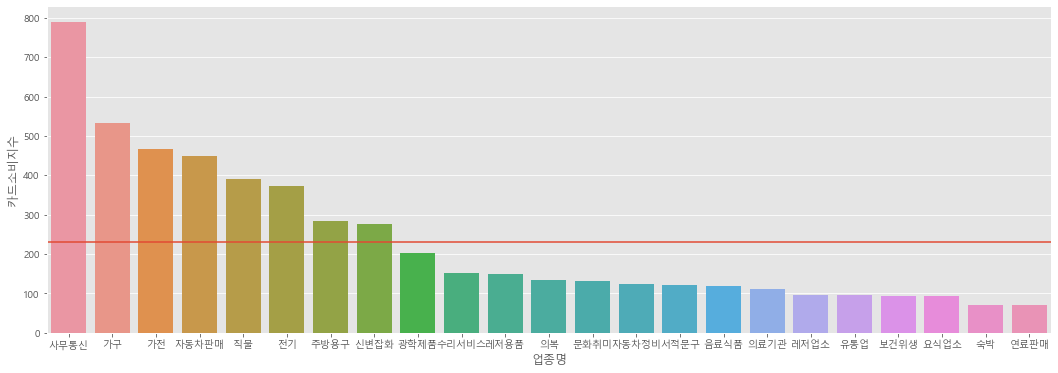

In [1310]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '카드소비지수')

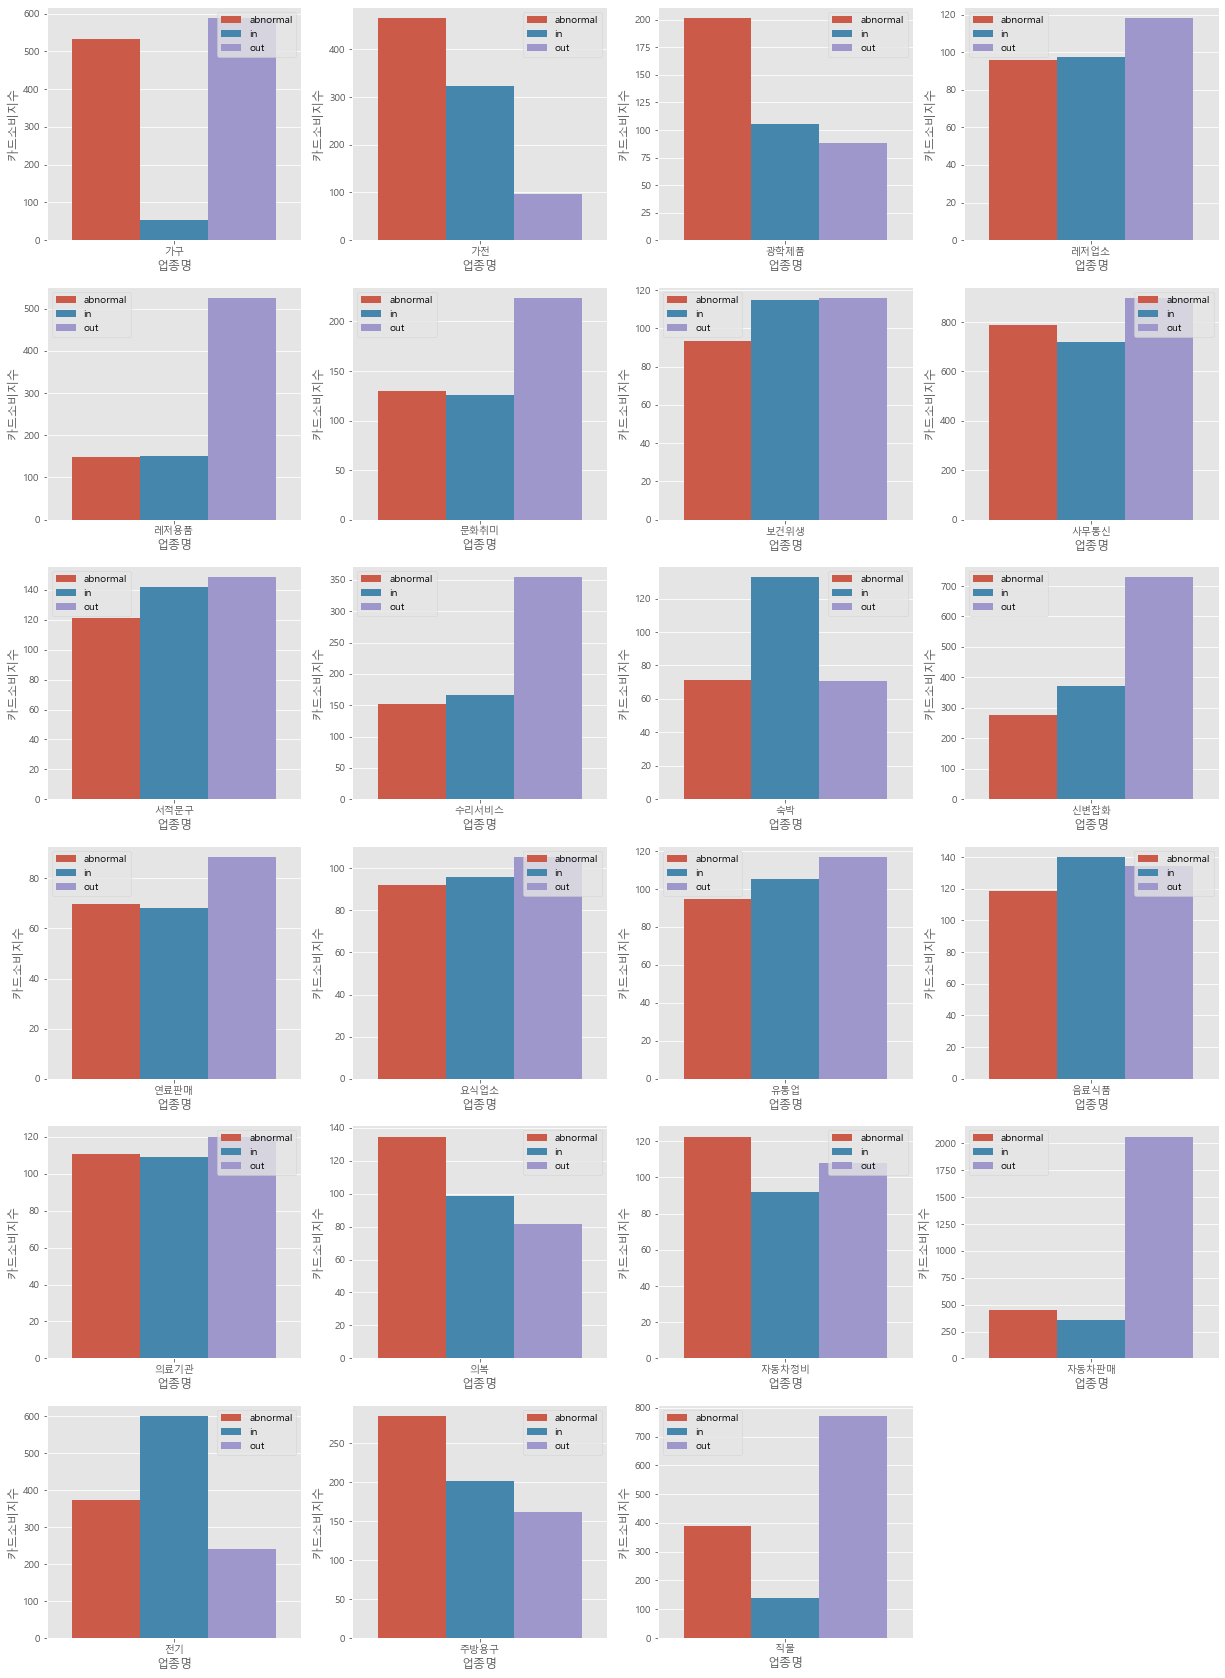

In [1311]:
get_plot_by_total_line(df_cluster, '카드소비지수')

# 물류 송장 건수

In [1312]:
cj_index_line = get_line_index_table(cj, '물류건수')
cj_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '물류건수_2019', '물류건수_2020']

cj_index_line_sep = cj_index_line[cj_index_line['주차'].isin(range(19,22))]

cj_index_line_sep = cj_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

cj_index_line_sep

,주차,시명,구명,행정동명,업종명,물류건수_2019,물류건수_2020,그룹
0,19,대구광역시,수성구,고산1동,가구/인테리어,262,579,abnormal
1,19,대구광역시,수성구,고산1동,도서/음반,733,1160,abnormal
2,19,대구광역시,수성구,고산1동,디지털/가전,567,1137,abnormal
3,19,대구광역시,수성구,고산1동,생활건강,1424,2946,abnormal
4,19,대구광역시,수성구,고산1동,스포츠/레저,120,192,abnormal
...,...,...,...,...,...,...,...,...
1765,21,서울특별시,중구,회현동,식품,1959,2270,abnormal
1766,21,서울특별시,중구,회현동,출산/육아,21,17,abnormal
1767,21,서울특별시,중구,회현동,패션의류,1331,1159,abnormal
1768,21,서울특별시,중구,회현동,패션잡화,848,812,abnormal


In [1313]:
# 물류소비지수 생성
# 2019년의 동주차 이용 건수을 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 판매가 변화했는지 지수로 산출
cj_index_line_sep['물류소비지수'] = (cj_index_line_sep['물류건수_2020']  * 100) / cj_index_line_sep['물류건수_2019']
# cj_index_line_sep['물류소비지수'] = get_scaled(cj_index_line_sep, '물류소비지수')

## 19-21주차의 전반적인 경향

In [1314]:
df = cj_index_line_sep.pivot_table(index='업종명', values='물류소비지수', aggfunc='mean').reset_index()

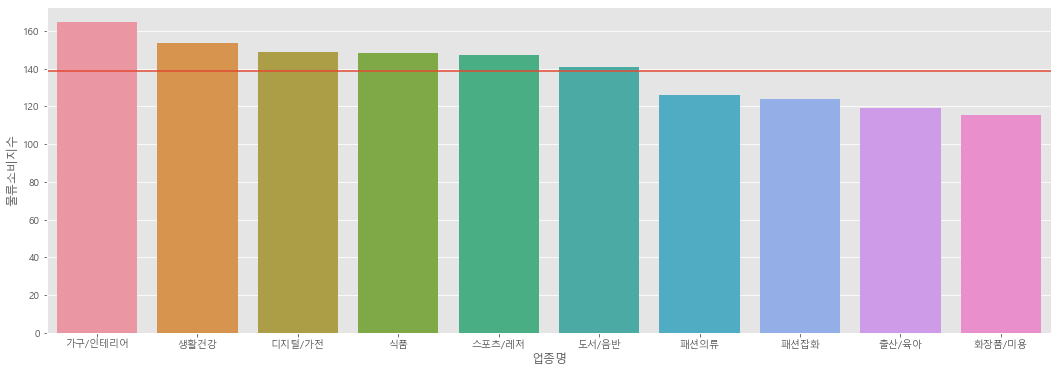

In [1315]:
get_plot_by_line(df, '물류소비지수')

### 나눈 지역별로 보기

In [1316]:
df_cluster = cj_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '물류소비지수', aggfunc='mean').reset_index()

### 1. In (물류지수가 높은 지역)

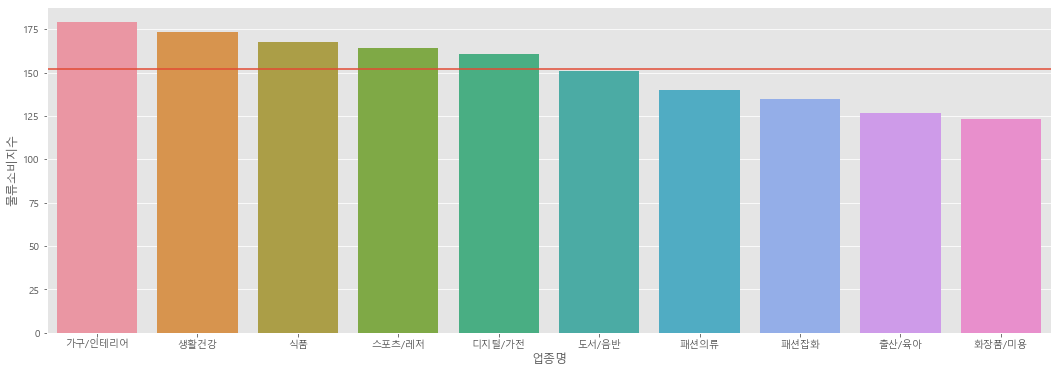

In [1317]:
df_cluster_in = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_in.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_in, '물류소비지수')

### 2. Out (외출 지수가 높은 지역)

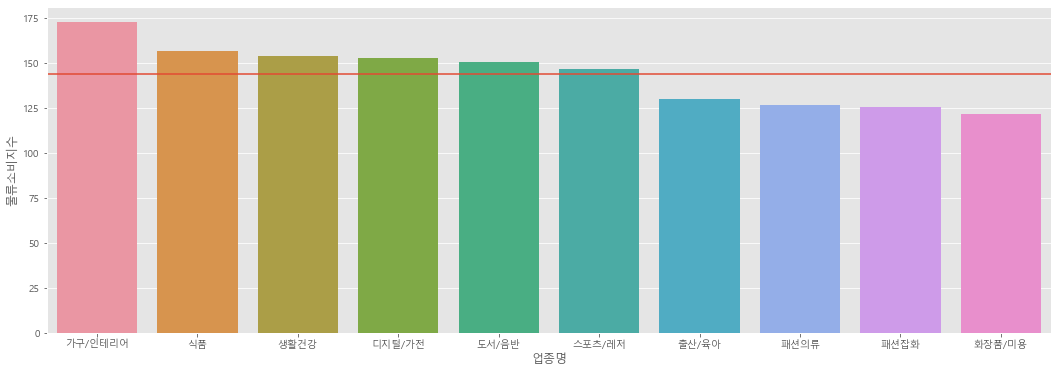

In [1318]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '물류소비지수')

### 3. abnormal (이상한 애들)

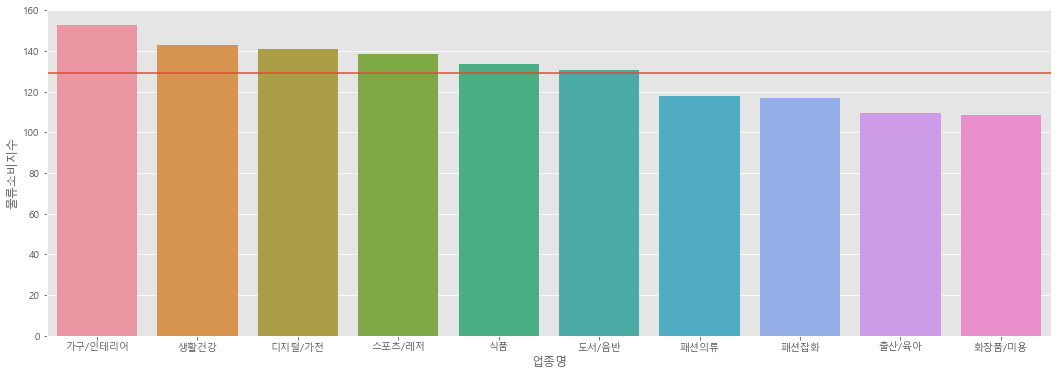

In [1320]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '물류소비지수')

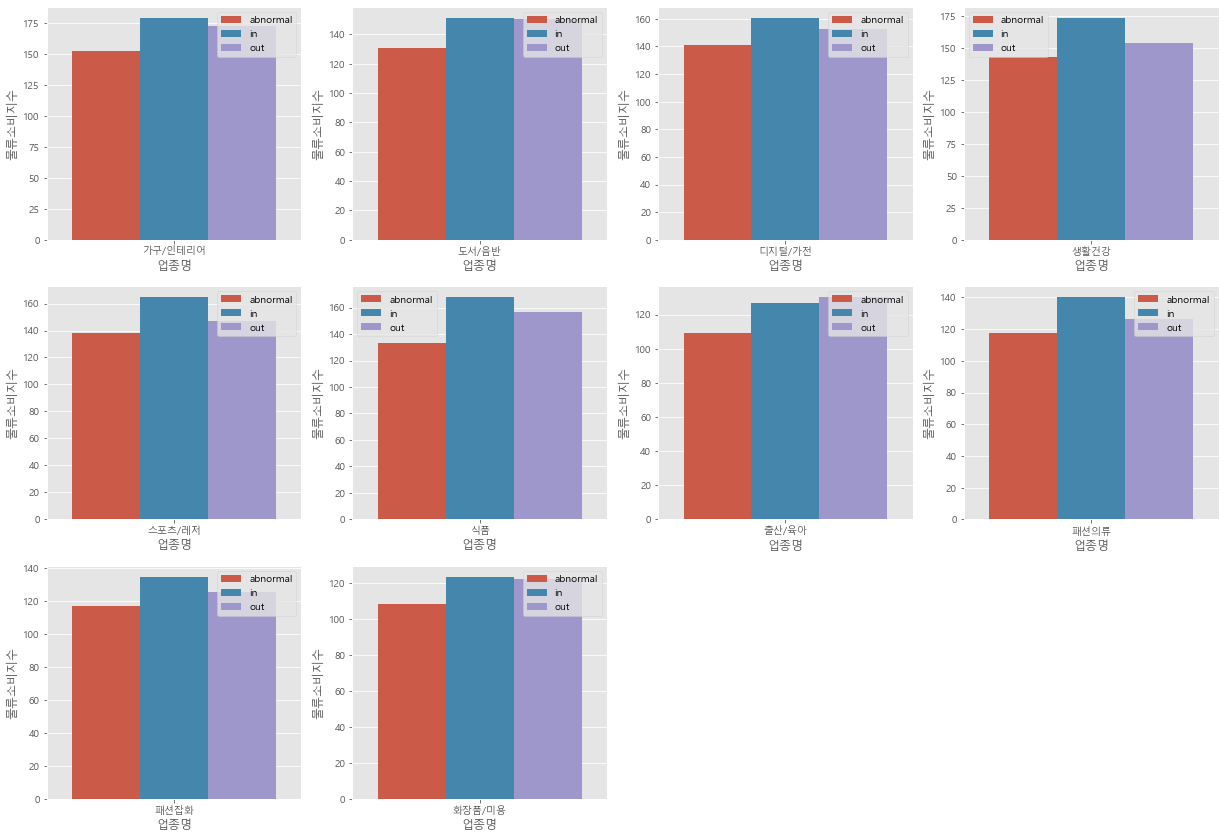

In [1321]:
get_plot_by_total_line(df_cluster, '물류소비지수')

# 유통데이터 

In [1322]:
# gs 데이터 재조구조화
gs_melt = pd.melt(gs, id_vars=['일자','시명','구명', '행정동명','주차','년'], value_vars=['식사_비중', '간식_비중', '마실거리_비중', '홈&리빙_비중',
       '헬스&뷰티_비중', '취미&여가활동_비중', '사회활동_비중', '임신/육아_비중'], var_name=['업종명'], value_name='유통지수')

gs_index_line = get_line_index_table(gs_melt, '유통지수')
gs_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '유통지수_2019', '유통지수_2020']

gs_index_line_sep = gs_index_line[gs_index_line['주차'].isin(range(19,22))]

gs_index_line_sep = gs_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

gs_index_line_sep

,주차,시명,구명,행정동명,업종명,유통지수_2019,유통지수_2020,그룹
0,19,대구광역시,수성구,고산1동,간식_비중,1.346711,1.385509,abnormal
1,19,대구광역시,수성구,고산1동,마실거리_비중,2.895254,2.757717,abnormal
2,19,대구광역시,수성구,고산1동,사회활동_비중,0.035717,0.048464,abnormal
3,19,대구광역시,수성구,고산1동,식사_비중,1.953787,1.839588,abnormal
4,19,대구광역시,수성구,고산1동,임신/육아_비중,0.035650,0.026816,abnormal
...,...,...,...,...,...,...,...,...
1411,21,서울특별시,중구,회현동,식사_비중,1.918850,2.041332,abnormal
1412,21,서울특별시,중구,회현동,임신/육아_비중,0.020066,0.025276,abnormal
1413,21,서울특별시,중구,회현동,취미&여가활동_비중,0.019544,0.019562,abnormal
1414,21,서울특별시,중구,회현동,헬스&뷰티_비중,0.410422,0.681340,abnormal


In [1323]:
# 유통소비지수 생성
# 2019년의 동주차 유통 지수를 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 유통지수가 변했는지 지수로 산출
gs_index_line_sep['유통소비지수'] = (gs_index_line_sep['유통지수_2020']  * 100) / gs_index_line_sep['유통지수_2019']
# gs_index_line_sep['유통소비지수'] = get_scaled(gs_index_line_sep, '유통소비지수')

## 19-21주차의 전반적인 경향

In [1324]:
df = gs_index_line_sep.pivot_table(index='업종명', values='유통소비지수', aggfunc='mean').reset_index()

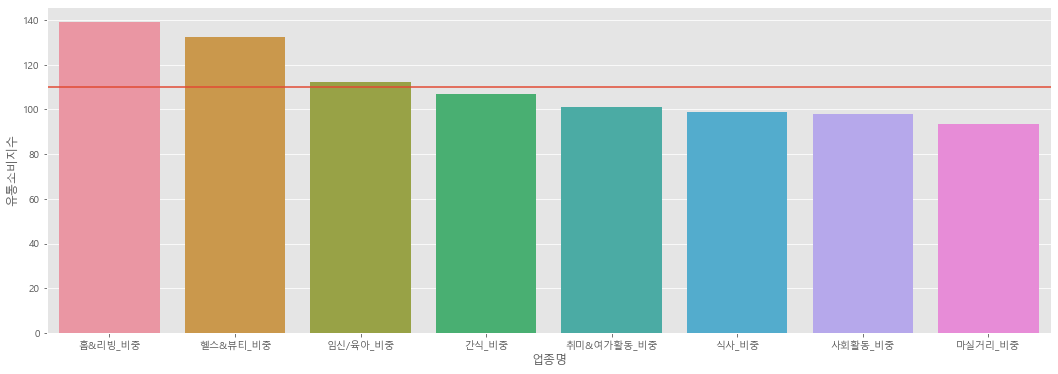

In [1325]:
get_plot_by_line(df, '유통소비지수')

### 나눈 지역별로 보기

In [1326]:
df_cluster = gs_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '유통소비지수', aggfunc='mean').reset_index()

### 1. In (물류지수가 높은 지역)

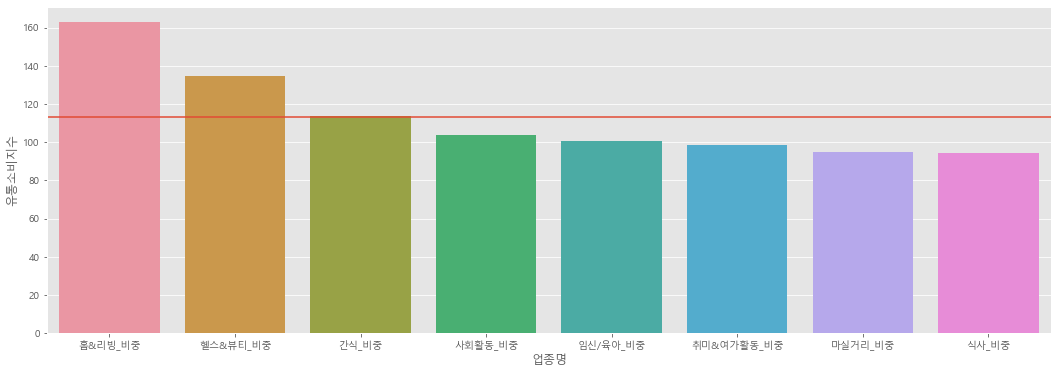

In [1327]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '유통소비지수')

### 2. Out (외출 지수가 높은 지역)

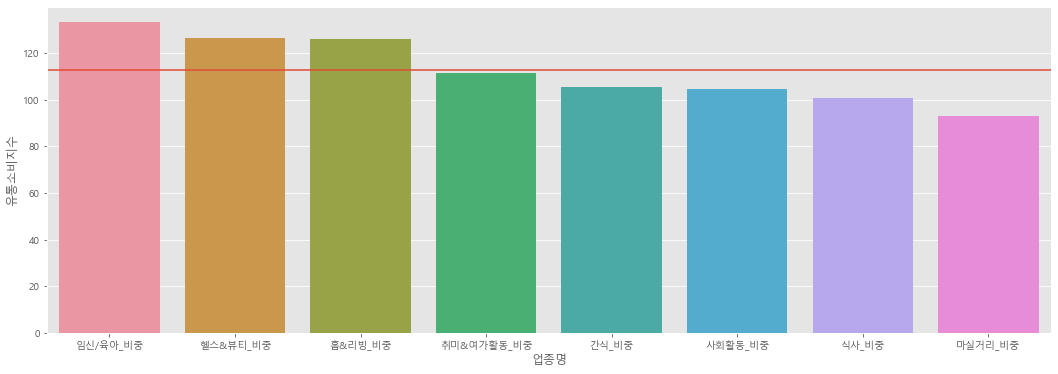

In [1328]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '유통소비지수')

### 3. abnormal (이상한 애들)

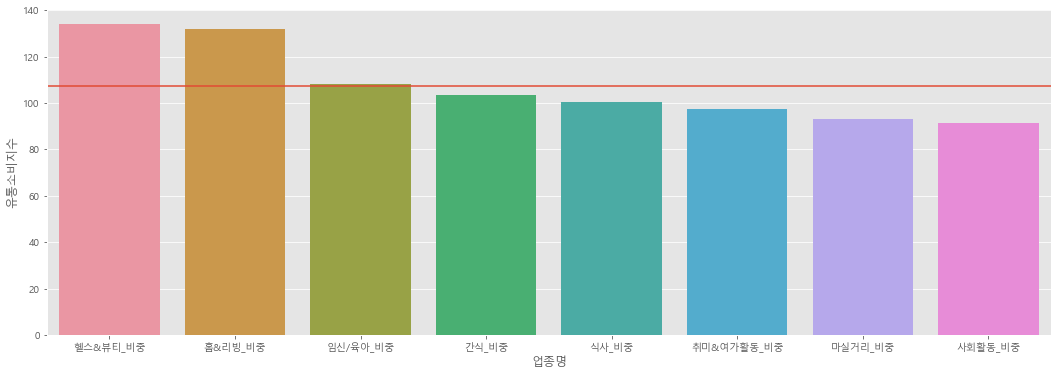

In [1329]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '유통소비지수')

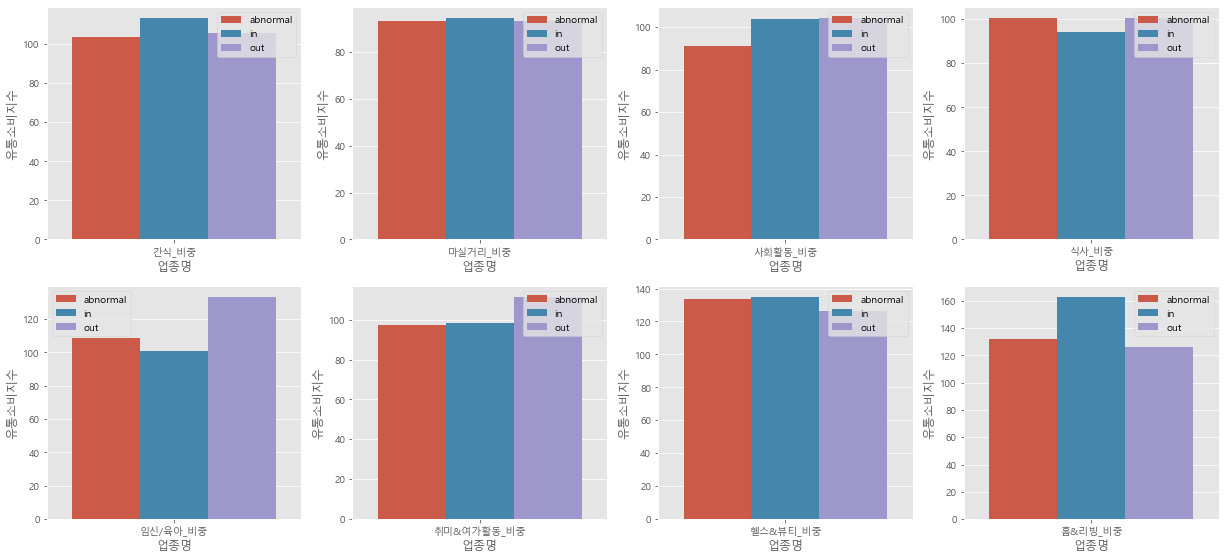

In [1330]:
get_plot_by_total_line(df_cluster, '유통소비지수')